In [1]:
import numpy as np
import xarray as xr
import netCDF4
import os
import datetime
import matplotlib.pyplot as plt 
from matplotlib import cm
import shutil
from datetime import datetime, timedelta
import glob
import datetime as dt
from os import path
import cartopy.crs as ccrs
import fsspec
import sys
import seaborn as sns
import os
from datetime import timezone
from scipy.stats import rankdata
xr.set_options(keep_attrs=True)
#plt.style.use('dark_background')
import rioxarray as rio
#import xesmf as xe
import pandas as pd

# AUTHOR INFORMATION

Author: Martin Wegmann

Contact: martin.wegmann@unibe.ch

Data availability: Data is from Marty, C., Michel, A., Jonas, T. (2025). SPASS - new gridded climatological snow datasets for Switzerland. EnviDat. https://www.doi.org/10.16904/envidat.580.

Data Description: https://tc.copernicus.org/articles/19/4391/2025/

Goal: Goal of this notebook is to create plots that communicate the snow depth evolution over Switzerland with time. This is a partner project with https://www.unisg.ch/.

# FUNCTIONS

In [2]:
##### enter custom colormap
def custom_div_cmap(numcolors=11, name='custom_div_cmap',
                    mincol='red', midcol='white', maxcol='blue'):
    """ Create a custom diverging colormap with three colors
    
    Default is blue to white to red with 11 colors.  Colors can be specified
    in any way understandable by matplotlib.colors.ColorConverter.to_rgb()
    """

    from matplotlib.colors import LinearSegmentedColormap 
    
    cmap = LinearSegmentedColormap.from_list(name=name, 
                                             colors =[mincol, midcol, maxcol],
                                             N=numcolors)
    return cmap
bwr_custom = custom_div_cmap(17)


In [3]:
def plotting_ranked_heatmap(data,variable,plot_folder,cmap,ranked_pos=True):
    years=np.unique(data.time.dt.year.values)
    amount_years=len(years)
    last_month=data[variable].time.dt.month[-1].values
    last_year=data[variable].time.dt.year[-1].values
    x = np.arange(1964,last_year+1,2)
    strings = ["%.0f" % number for number in x]
    last_month=data[variable].time.dt.month[-1].values
    last_year=data[variable].time.dt.year[-1].values
    if last_month!=1:
        if ranked_pos==True:
            values=data[variable].values[:-1]
            b=np.repeat(-9999,12+1-last_month)
            values=data[variable].values[:-1]
            c=np.repeat(np.nan,12+1-last_month)
            values_NAN=np.concatenate((values, c), axis=None)
            values_9999=np.concatenate((values, b), axis=None)
            values_NAN_reshaped=values_NAN.reshape(amount_years,12)
            values_9999_reshaped=values_9999.reshape(amount_years,12)
        else:
            values=data[variable].values[:-1]
            b=np.repeat(9999,12+1-last_month)
            values=data[variable].values[:-1]
            c=np.repeat(np.nan,12+1-last_month)
            values_NAN=np.concatenate((values, c), axis=None)
            values_9999=np.concatenate((values, b), axis=None)
            values_NAN_reshaped=values_NAN.reshape(amount_years,12)
            values_9999_reshaped=values_9999.reshape(amount_years,12)

        reshaped_data_climatology=data[variable].sel(time=slice("1981-01-31","2010-12-31")).values.reshape(30,12)
        average_monthly_value=reshaped_data_climatology.mean(axis=0)
        
        monthly_anomalies_nan=values_NAN_reshaped-average_monthly_value
        monthly_anomalies_9999=values_9999_reshaped-average_monthly_value
        empty_ranks=np.zeros_like(monthly_anomalies_nan)





        empty_ranks=np.zeros_like(monthly_anomalies_nan)
        if ranked_pos==True:
            for i in range(12):
                empty_ranks[:,i]=(rankdata(monthly_anomalies_9999[:,i])-amount_years)*-1+1
        else:
            for i in range(12):
                empty_ranks[:,i]=rankdata(monthly_anomalies_9999[:,i])
        ranks_first=empty_ranks==1*1
        ranks_second=(empty_ranks==2)*2
        ranks_third=(empty_ranks==3)*3
        ranks_third=ranks_third.astype('float')
        ranks_second=ranks_second.astype('float')
        ranks_first=ranks_first.astype('float')
        ranks_third[ranks_third==0]=np.nan
        ranks_second[ranks_second==0]=np.nan
        ranks_first[ranks_first==0]=np.nan
        vmax=round(np.nanmax(monthly_anomalies_nan),4)
        
        
    else:
        reshaped_data_climatology=data[variable].sel(time=slice("1981-01-31","2010-12-31")).values.reshape(30,12)
        average_monthly_value=reshaped_data_climatology.mean(axis=0)
        values=data[variable].values[:-1]

        monthly_anomalies_nan=values.reshape(amount_years-1,12)-average_monthly_value
        monthly_anomalies_9999=values.reshape(amount_years-1,12)-average_monthly_value
        empty_ranks=np.zeros_like(monthly_anomalies_nan)





        empty_ranks=np.zeros_like(monthly_anomalies_nan)
        if ranked_pos==True:
            for i in range(12):
                empty_ranks[:,i]=(rankdata(monthly_anomalies_9999[:,i])-amount_years)*-1+1
        else:
            for i in range(12):
                empty_ranks[:,i]=rankdata(monthly_anomalies_9999[:,i])
        ranks_first=empty_ranks==1*1
        ranks_second=(empty_ranks==2)*2
        ranks_third=(empty_ranks==3)*3
        ranks_third=ranks_third.astype('float')
        ranks_second=ranks_second.astype('float')
        ranks_first=ranks_first.astype('float')
        ranks_third[ranks_third==0]=np.nan
        ranks_second[ranks_second==0]=np.nan
        ranks_first[ranks_first==0]=np.nan
        vmax=round(np.nanmax(monthly_anomalies_nan),4)

    
    fig, axs = plt.subplots(1, 1, figsize=(10.2,3.2), dpi= 300)
    ax = sns.heatmap(monthly_anomalies_nan.transpose(), linewidth=0.5, linecolor='white',vmin=vmax*-1,vmax=vmax,cmap=cmap)
    ax = sns.heatmap(ranks_third.transpose(), linewidth=0.5, linecolor='white',cmap=cmap,alpha=0, cbar=False, annot=True)
    ax = sns.heatmap(ranks_second.transpose(), linewidth=0.5, linecolor='white',cmap=cmap,alpha=0, cbar=False, annot=True)
    ax = sns.heatmap(ranks_first.transpose(), linewidth=0.5, linecolor='white',cmap=cmap,alpha=0, cbar=False, annot=True)
    ax.set(xlabel="Year", ylabel="Month")
    ax.set_yticklabels(["01","02" ,"03","04","05","06","07","08","09","10","11","12"])
    ax.set_yticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"])
    ax.set_xticklabels(strings)
    #ax.set_xticks([0.5,10.5,20.5,30.5,40.5])
    ax.set_xticks([0.5,10.5,20.5,30.5,40.5,50.5])


    #ax.set_xticklabels(["1973","1983","1993","2003","2014"])
    ax.set_xticklabels(["1963","1973","1983","1993","2003","2013"])
    plt.yticks(rotation = 0)
    plt.xticks(rotation = 90)
    plt.yticks(rotation = 0)
    plt.xticks(rotation = 0)
    plt.title("Switzerland mean monthly snow depth anomalies wrt 1981-2010")
    cbar = ax.collections[0].colorbar
    cbar.set_label('[cm]', fontsize=12)  
    plt.tight_layout()
    save_name="ERA5_heatmap_"+variable
    plt.savefig(plot_folder+save_name+"_white.pdf")
    plt.savefig(plot_folder+save_name+"_white.png")
    plt.show()
    return 

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_anom_ts_2d(data, var, plot_folder, cmap, resolution, ncols=10):
    data2plot = data[var]
    maxmin = [data2plot.max().values, data2plot.min().values]
    range = np.max(np.abs(maxmin))
    years = np.unique(data.year.values)
    
    print(data2plot.shape)
    
    plot = data2plot.plot(
        vmax=100,
        vmin=-100,
        #vmax=range,
        #vmin=-range,
        cmap=cmap,
        levels=8,
        col="year",
        col_wrap=ncols
    )
    
    for i, ax in enumerate(plot.axs.flat):
        year_title = i + 1963
        ax.set_title(str(year_title))
        
        # Remove all ticks and labels
        ax.tick_params(
            axis='both',
            which='both',
            bottom=False,
            top=False,
            left=False,
            right=False,
            labelbottom=False,
            labelleft=False
        )
        
        # Remove axis label descriptions (e.g., "longitude", "latitude")
        ax.set_xlabel("")
        ax.set_ylabel("")

    plot.cbar.ax.tick_params(labelsize=20)  # Tick label size
    plot.cbar.set_label("[cm]", fontsize=20)  # Set colorbar label (edit as needed)

    plt.draw()
    plt.savefig(f"{plot_folder}{var}_{resolution}_anoms_white.png")
    plt.savefig(f"{plot_folder}{var}_{resolution}_anoms_white.pdf")
    print(f"Stored in {plot_folder}{var}_{resolution}_anoms.png")
    return


In [5]:
def max_consecutive_ones_in_da(da_year):
    diff = da_year.astype(int).diff(dim='time')

    first_time = da_year.time.values[0]
    prepend = xr.DataArray([1], dims=['time'], coords={'time': [first_time]})

    change = xr.concat([prepend, diff], dim='time').astype(bool)

    groups = change.cumsum(dim='time')
    groups = groups.assign_coords(time=da_year.time)

    grouped = da_year.groupby(groups)
    run_lengths = [group.sum().item() for _, group in grouped if group[0].item() == 1]

    max_len = max(run_lengths) if run_lengths else 0

    # Return as xarray.DataArray scalar
    return xr.DataArray(max_len)

In [6]:
# Step 2: Function to get bin edges from da2 coords
def get_bin_edges(coords):
    edges = (coords[:-1].values + coords[1:].values) / 2
    start_edge = coords.values[0] - (edges[0] - coords.values[0])
    end_edge = coords.values[-1] + (coords.values[-1] - edges[-1])
    return np.concatenate(([start_edge], edges, [end_edge]))

In [7]:
# Step 4: Convert IntervalIndex bin coords to bin centers for numeric coords
def interval_to_center(dataarray):
    # Convert coordinate DataArray to pandas IntervalIndex
    intervals = dataarray.variable.to_index()
    return [(interval.left + interval.right) / 2 for interval in intervals]


# SETUP

In [8]:
data_folder="/Volumes/SPARK3/meteo_swiss/snow/"
plot_folder=data_folder+"plots/"

# READ IN DATA

## SNOW DATA

In [9]:
CH_SD_original=xr.open_dataset(data_folder+"HSCLQMD_ch01h.swiss.lv95_WY_1962_2023.nc")

/Users/mwegmann/anaconda3/envs/imac311_2/lib/python3.11/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)


### postprocessing

In [10]:
# Focus on the last complete 60 years , convert to cm
CH_SD=CH_SD_original.sel(time=(slice("1963","2022")))*100

In [11]:
CH_SD_mon=CH_SD.resample(time='1M').mean() 

/Users/mwegmann/anaconda3/envs/imac311_2/lib/python3.11/site-packages/xarray/groupers.py:509: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [12]:
CH_SD_mon_fieldmean=CH_SD_mon.mean(dim=("N", "E"))

In [13]:
concat_files=[CH_SD_mon_fieldmean,CH_SD_original.resample(time='1M').mean().mean(dim=("N", "E")).sel(time=("2023-01"))]

/Users/mwegmann/anaconda3/envs/imac311_2/lib/python3.11/site-packages/xarray/groupers.py:509: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [14]:
CH_SD_mon_fieldmean_ext=xr.concat(concat_files,dim="time")

In [15]:

# SKI SEASON

# Select only the months December (12) through April (4)
# This involves selecting Dec (12), Jan (1), Feb (2), Mar (3), Apr (4)
months = [12, 1, 2, 3, 4]

# Use .where() to mask and drop other months
dec_to_may = CH_SD_mon.where(CH_SD_mon['time.month'].isin(months), drop=True)

# Now take the mean over the selected time period
# If you want the mean over all years' Dec–May, do:
mean_dec_to_may = dec_to_may.groupby("time.year").mean(dim="time")

# Or, if you want a single mean value across all Dec–May data:
overall_mean_dec_to_may = dec_to_may.mean(dim="time")
mean_dec_to_may_fldmean=mean_dec_to_may.mean(dim=("N", "E"))

In [16]:

# SKI SEASON

# Select only the months December (12) through April (4)
# This involves selecting Dec (12), Jan (1), Feb (2), Mar (3), Apr (4)
months = [12, 1, 2, 3, 4]

# Use .where() to mask and drop other months
dec_to_may_daily = CH_SD.where(CH_SD['time.month'].isin(months), drop=True)
dec_to_may_daily_fldmean=dec_to_may_daily.mean(dim=("N", "E"))

In [17]:
# ski resort extraction
CH_SD_adelboden=CH_SD.sel(E=2609302,N=1149113,method="nearest")
CH_SD_adelboden_onem=CH_SD_adelboden>50
CH_SD_adelboden_onem_test=CH_SD_adelboden>50
CH_SD_adelboden_onem=CH_SD_adelboden_onem.groupby("time.year").sum(dim="time").HSCLQMD

In [18]:
# ski resort extraction
CH_SD_zermatt=CH_SD.sel(E=2624264.205,N=1096736.840,method="nearest")
CH_SD_zermatt_onem=CH_SD_zermatt>50
CH_SD_zermatt_onem_test=CH_SD_zermatt>50
CH_SD_zermatt_onem=CH_SD_zermatt_onem.groupby("time.year").sum(dim="time").HSCLQMD

In [19]:
# ski resort extraction
CH_SD_stmoritz=CH_SD.sel(E=2784248.087,N=1152506.491,method="nearest")
CH_SD_stmoritz_onem=CH_SD_stmoritz>50
CH_SD_stmoritz_onem_test=CH_SD_stmoritz>50
CH_SD_stmoritz_onem=CH_SD_stmoritz_onem.groupby("time.year").sum(dim="time").HSCLQMD

In [20]:
# ski resort extraction
CH_SD_davos=CH_SD.sel(E=2782998.931,N=1186335.249,method="nearest")
CH_SD_davos_onem=CH_SD_davos>50
CH_SD_davos_onem_test=CH_SD_davos>50
CH_SD_davos_onem=CH_SD_davos_onem.groupby("time.year").sum(dim="time").HSCLQMD

In [21]:
# ski resort extraction
CH_SD_verbier=CH_SD.sel(E=2583788,N=1104968,method="nearest")
CH_SD_verbier_onem=CH_SD_verbier>50
CH_SD_verbier_onem_test=CH_SD_verbier>50
CH_SD_verbier_onem=CH_SD_verbier_onem.groupby("time.year").sum(dim="time").HSCLQMD

In [22]:
# ski resort extraction
CH_SD_scuol=CH_SD.sel(E=2818622, N=1187062,method="nearest")
CH_SD_scuol_onem=CH_SD_scuol>50
CH_SD_scuol_onem_test=CH_SD_scuol>50
CH_SD_scuol_onem=CH_SD_scuol_onem.groupby("time.year").sum(dim="time").HSCLQMD

In [23]:
# city extraction
CH_SD_bern=CH_SD.sel(E=2600000,N=1200000,method="nearest")
CH_SD_bern_christmas=CH_SD_bern.sel(time=(CH_SD_bern['time'].dt.month == 12) & (CH_SD_bern['time'].dt.day == 25))>5

In [24]:
# city extraction
CH_SD_geneva=CH_SD.sel(E=2500532,N=1117325,method="nearest")
CH_SD_geneva_christmas=CH_SD_geneva.sel(time=(CH_SD_geneva['time'].dt.month == 12) & (CH_SD_geneva['time'].dt.day == 25))>5

In [25]:
# city extraction
CH_SD_lausanne=CH_SD.sel(E=2538291,N=1152330,method="nearest")
CH_SD_lausanne_christmas=CH_SD_lausanne.sel(time=(CH_SD_lausanne['time'].dt.month == 12) & (CH_SD_lausanne['time'].dt.day == 25))>5

In [26]:
# city extraction
CH_SD_zurich=CH_SD.sel(E=2683484.331,N=1247341.058,method="nearest")
CH_SD_zurich_christmas=CH_SD_zurich.sel(time=(CH_SD_zurich['time'].dt.month == 12) & (CH_SD_zurich['time'].dt.day == 25))>5


In [27]:
# city extraction
CH_SD_basel=CH_SD.sel(E=2611220,N=1267503,method="nearest")
CH_SD_basel_christmas=CH_SD_basel.sel(time=(CH_SD_basel['time'].dt.month == 12) & (CH_SD_basel['time'].dt.day == 25))>5

## DEM DATA

Source of the DEM data is https://www.swisstopo.admin.ch/de/hoehenmodell-dhm25-200m, respective http://data.geo.admin.ch/ch.swisstopo.digitales-hoehenmodell_25/data.zip

In [28]:

# Load the xyz data
df = pd.read_csv(data_folder+'DHM200.xyz', delim_whitespace=True, names=['x', 'y', 'z'])
# Create a 2D grid (x = columns, y = rows)
grid = df.pivot(index='y', columns='x', values='z')

# Convert to DataArray
da = xr.DataArray(grid.values, coords=[grid.index, grid.columns], dims=["y", "x"])
da.rio.write_crs("EPSG:21781", inplace=True)
dem = da.rio.reproject("EPSG:2056")


/var/folders/9m/drx7l0bs2dl0tg8qkv0_nz7w0000gp/T/ipykernel_40227/841929767.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(data_folder+'DHM200.xyz', delim_whitespace=True, names=['x', 'y', 'z'])
/Users/mwegmann/anaconda3/envs/imac311_2/lib/python3.11/site-packages/pyproj/crs/_cf1x8.py:514: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(
/Users/mwegmann/anaconda3/envs/imac311_2/lib/python3.11/site-packages/pyproj/crs/_cf1x8.py:514: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


In [29]:
# Alternative data from Christoph
#dem = (rio.open_rasterio(data_folder+"BAFU_DEM_2020_1000.txt").rename({"y":"chy","x":"chx"}).isel(band=0, drop=True))

#if value is -9999 mark it as missing
#dem = xr.where(dem == -9999, np.nan,dem)
#just for this step, shift dem grid by 500 to make it compatible with DS grid
#dem["chx"] = dem["chx"].values-500
#dem["chy"] = dem["chy"].values-500

### postprocessing

In [30]:
# masking regions based on elevation

In [31]:
import numpy as np
import xarray as xr

da1=dem
da2=dec_to_may_daily.HSCLQMD

# Step 1: Create boolean mask on da1
mask_da1 = da1 > 3000



y_bins = get_bin_edges(da2.N)
x_bins = get_bin_edges(da2.E)

# Step 3: Aggregate mask_da1 by bins on y and x
mask_coarse_y = mask_da1.groupby_bins('y', y_bins).max(dim='y')
mask_coarse = mask_coarse_y.groupby_bins('x', x_bins).max(dim='x')



mask_coarse = mask_coarse.assign_coords(
    y_bins = interval_to_center(mask_coarse['y_bins']),
    x_bins = interval_to_center(mask_coarse['x_bins'])
)

# Step 5: Rename dims to match da2's spatial dims
mask_coarse = mask_coarse.rename({'y_bins': 'N', 'x_bins': 'E'})

# Step 6: Apply mask on da2
masked_da2 = da2.where(mask_coarse)

# Optional: drop all-NaN along spatial dims
masked_da2_3000 = masked_da2.dropna(dim='N', how='all').dropna(dim='E', how='all')
masked_da2_3000_fldmean=masked_da2_3000.mean(dim=("N", "E"))


In [32]:
import numpy as np
import xarray as xr

da1=dem
da2=dec_to_may_daily.HSCLQMD

# Step 1: Create boolean mask on da1
mask_da1 = da1 > 2000



y_bins = get_bin_edges(da2.N)
x_bins = get_bin_edges(da2.E)

# Step 3: Aggregate mask_da1 by bins on y and x
mask_coarse_y = mask_da1.groupby_bins('y', y_bins).max(dim='y')
mask_coarse = mask_coarse_y.groupby_bins('x', x_bins).max(dim='x')



mask_coarse = mask_coarse.assign_coords(
    y_bins = interval_to_center(mask_coarse['y_bins']),
    x_bins = interval_to_center(mask_coarse['x_bins'])
)

# Step 5: Rename dims to match da2's spatial dims
mask_coarse = mask_coarse.rename({'y_bins': 'N', 'x_bins': 'E'})

# Step 6: Apply mask on da2
masked_da2 = da2.where(mask_coarse)

# Optional: drop all-NaN along spatial dims
masked_da2_234 = masked_da2.dropna(dim='N', how='all').dropna(dim='E', how='all')
masked_da2_234_fldmean=masked_da2_234.mean(dim=("N", "E"))


In [33]:
import numpy as np
import xarray as xr

da1=dem
da2=mean_dec_to_may.HSCLQMD

# Step 1: Create boolean mask on da1
mask_da1 = da1 > 3000



y_bins = get_bin_edges(da2.N)
x_bins = get_bin_edges(da2.E)

# Step 3: Aggregate mask_da1 by bins on y and x
mask_coarse_y = mask_da1.groupby_bins('y', y_bins).max(dim='y')
mask_coarse = mask_coarse_y.groupby_bins('x', x_bins).max(dim='x')



mask_coarse = mask_coarse.assign_coords(
    y_bins = interval_to_center(mask_coarse['y_bins']),
    x_bins = interval_to_center(mask_coarse['x_bins'])
)

# Step 5: Rename dims to match da2's spatial dims
mask_coarse = mask_coarse.rename({'y_bins': 'N', 'x_bins': 'E'})

# Step 6: Apply mask on da2
masked_da2 = da2.where(mask_coarse)

# Optional: drop all-NaN along spatial dims
masked_da2_3000_ym = masked_da2.dropna(dim='N', how='all').dropna(dim='E', how='all')
masked_da2_3000_ym_fldmean=masked_da2_3000_ym.mean(dim=("N", "E"))


In [34]:
import numpy as np
import xarray as xr

da1=dem
da2=dec_to_may_daily.HSCLQMD

# Step 1: Create boolean mask on da1
mask_da1 = (da1 < 3000) & (da1 > 2000)



y_bins = get_bin_edges(da2.N)
x_bins = get_bin_edges(da2.E)

# Step 3: Aggregate mask_da1 by bins on y and x
mask_coarse_y = mask_da1.groupby_bins('y', y_bins).max(dim='y')
mask_coarse = mask_coarse_y.groupby_bins('x', x_bins).max(dim='x')



mask_coarse = mask_coarse.assign_coords(
    y_bins = interval_to_center(mask_coarse['y_bins']),
    x_bins = interval_to_center(mask_coarse['x_bins'])
)

# Step 5: Rename dims to match da2's spatial dims
mask_coarse = mask_coarse.rename({'y_bins': 'N', 'x_bins': 'E'})

# Step 6: Apply mask on da2
masked_da2 = da2.where(mask_coarse)

# Optional: drop all-NaN along spatial dims
masked_da2_2000 = masked_da2.dropna(dim='N', how='all').dropna(dim='E', how='all')
masked_da2_2000_fldmean=masked_da2_2000.mean(dim=("N", "E"))



In [35]:
import numpy as np
import xarray as xr

da1=dem
da2=mean_dec_to_may.HSCLQMD

# Step 1: Create boolean mask on da1
mask_da1 = (da1 < 3000) & (da1 > 2000)



y_bins = get_bin_edges(da2.N)
x_bins = get_bin_edges(da2.E)

# Step 3: Aggregate mask_da1 by bins on y and x
mask_coarse_y = mask_da1.groupby_bins('y', y_bins).max(dim='y')
mask_coarse = mask_coarse_y.groupby_bins('x', x_bins).max(dim='x')



mask_coarse = mask_coarse.assign_coords(
    y_bins = interval_to_center(mask_coarse['y_bins']),
    x_bins = interval_to_center(mask_coarse['x_bins'])
)

# Step 5: Rename dims to match da2's spatial dims
mask_coarse = mask_coarse.rename({'y_bins': 'N', 'x_bins': 'E'})

# Step 6: Apply mask on da2
masked_da2 = da2.where(mask_coarse)

# Optional: drop all-NaN along spatial dims
masked_da2_2000_ym = masked_da2.dropna(dim='N', how='all').dropna(dim='E', how='all')
masked_da2_2000_ym_fldmean=masked_da2_2000_ym.mean(dim=("N", "E"))



In [36]:
import numpy as np
import xarray as xr

da1=dem
da2=dec_to_may_daily.HSCLQMD

# Step 1: Create boolean mask on da1
mask_da1 = (da1 < 2000) & (da1 > 1000)



y_bins = get_bin_edges(da2.N)
x_bins = get_bin_edges(da2.E)

# Step 3: Aggregate mask_da1 by bins on y and x
mask_coarse_y = mask_da1.groupby_bins('y', y_bins).max(dim='y')
mask_coarse = mask_coarse_y.groupby_bins('x', x_bins).max(dim='x')



mask_coarse = mask_coarse.assign_coords(
    y_bins = interval_to_center(mask_coarse['y_bins']),
    x_bins = interval_to_center(mask_coarse['x_bins'])
)

# Step 5: Rename dims to match da2's spatial dims
mask_coarse = mask_coarse.rename({'y_bins': 'N', 'x_bins': 'E'})

# Step 6: Apply mask on da2
masked_da2 = da2.where(mask_coarse)

# Optional: drop all-NaN along spatial dims
masked_da2_1000 = masked_da2.dropna(dim='N', how='all').dropna(dim='E', how='all')
masked_da2_1000_fldmean=masked_da2_1000.mean(dim=("N", "E"))


In [37]:
import numpy as np
import xarray as xr

da1=dem
da2=mean_dec_to_may.HSCLQMD

# Step 1: Create boolean mask on da1
mask_da1 = (da1 < 2000) & (da1 > 1000)



y_bins = get_bin_edges(da2.N)
x_bins = get_bin_edges(da2.E)

# Step 3: Aggregate mask_da1 by bins on y and x
mask_coarse_y = mask_da1.groupby_bins('y', y_bins).max(dim='y')
mask_coarse = mask_coarse_y.groupby_bins('x', x_bins).max(dim='x')



mask_coarse = mask_coarse.assign_coords(
    y_bins = interval_to_center(mask_coarse['y_bins']),
    x_bins = interval_to_center(mask_coarse['x_bins'])
)

# Step 5: Rename dims to match da2's spatial dims
mask_coarse = mask_coarse.rename({'y_bins': 'N', 'x_bins': 'E'})

# Step 6: Apply mask on da2
masked_da2 = da2.where(mask_coarse)

# Optional: drop all-NaN along spatial dims
masked_da2_1000_ym = masked_da2.dropna(dim='N', how='all').dropna(dim='E', how='all')
masked_da2_1000_ym_fldmean=masked_da2_1000_ym.mean(dim=("N", "E"))


In [38]:
import numpy as np
import xarray as xr

da1=dem
da2=dec_to_may_daily.HSCLQMD

# Step 1: Create boolean mask on da1
mask_da1 = da1 < 1000



y_bins = get_bin_edges(da2.N)
x_bins = get_bin_edges(da2.E)

# Step 3: Aggregate mask_da1 by bins on y and x
mask_coarse_y = mask_da1.groupby_bins('y', y_bins).max(dim='y')
mask_coarse = mask_coarse_y.groupby_bins('x', x_bins).max(dim='x')



mask_coarse = mask_coarse.assign_coords(
    y_bins = interval_to_center(mask_coarse['y_bins']),
    x_bins = interval_to_center(mask_coarse['x_bins'])
)

# Step 5: Rename dims to match da2's spatial dims
mask_coarse = mask_coarse.rename({'y_bins': 'N', 'x_bins': 'E'})

# Step 6: Apply mask on da2
masked_da2 = da2.where(mask_coarse)

# Optional: drop all-NaN along spatial dims
masked_da2_900 = masked_da2.dropna(dim='N', how='all').dropna(dim='E', how='all')
masked_da2_900_fldmean=masked_da2_900.mean(dim=("N", "E"))



In [39]:
import numpy as np
import xarray as xr

da1=dem
da2=dec_to_may_daily.HSCLQMD

# Step 1: Create boolean mask on da1
mask_da1 = da1 < 2000



y_bins = get_bin_edges(da2.N)
x_bins = get_bin_edges(da2.E)

# Step 3: Aggregate mask_da1 by bins on y and x
mask_coarse_y = mask_da1.groupby_bins('y', y_bins).max(dim='y')
mask_coarse = mask_coarse_y.groupby_bins('x', x_bins).max(dim='x')



mask_coarse = mask_coarse.assign_coords(
    y_bins = interval_to_center(mask_coarse['y_bins']),
    x_bins = interval_to_center(mask_coarse['x_bins'])
)

# Step 5: Rename dims to match da2's spatial dims
mask_coarse = mask_coarse.rename({'y_bins': 'N', 'x_bins': 'E'})

# Step 6: Apply mask on da2
masked_da2 = da2.where(mask_coarse)

# Optional: drop all-NaN along spatial dims
masked_da2_12 = masked_da2.dropna(dim='N', how='all').dropna(dim='E', how='all')
masked_da2_12_fldmean=masked_da2_12.mean(dim=("N", "E"))



In [40]:
import numpy as np
import xarray as xr

da1=dem
da2=mean_dec_to_may.HSCLQMD

# Step 1: Create boolean mask on da1
mask_da1 = da1 < 1000



y_bins = get_bin_edges(da2.N)
x_bins = get_bin_edges(da2.E)

# Step 3: Aggregate mask_da1 by bins on y and x
mask_coarse_y = mask_da1.groupby_bins('y', y_bins).max(dim='y')
mask_coarse = mask_coarse_y.groupby_bins('x', x_bins).max(dim='x')



mask_coarse = mask_coarse.assign_coords(
    y_bins = interval_to_center(mask_coarse['y_bins']),
    x_bins = interval_to_center(mask_coarse['x_bins'])
)

# Step 5: Rename dims to match da2's spatial dims
mask_coarse = mask_coarse.rename({'y_bins': 'N', 'x_bins': 'E'})

# Step 6: Apply mask on da2
masked_da2 = da2.where(mask_coarse)

# Optional: drop all-NaN along spatial dims
masked_da2_900_ym = masked_da2.dropna(dim='N', how='all').dropna(dim='E', how='all')
masked_da2_900_ym_fldmean=masked_da2_900_ym.mean(dim=("N", "E"))



# PLOTTING

## Snow in cities on Christmas 1/0

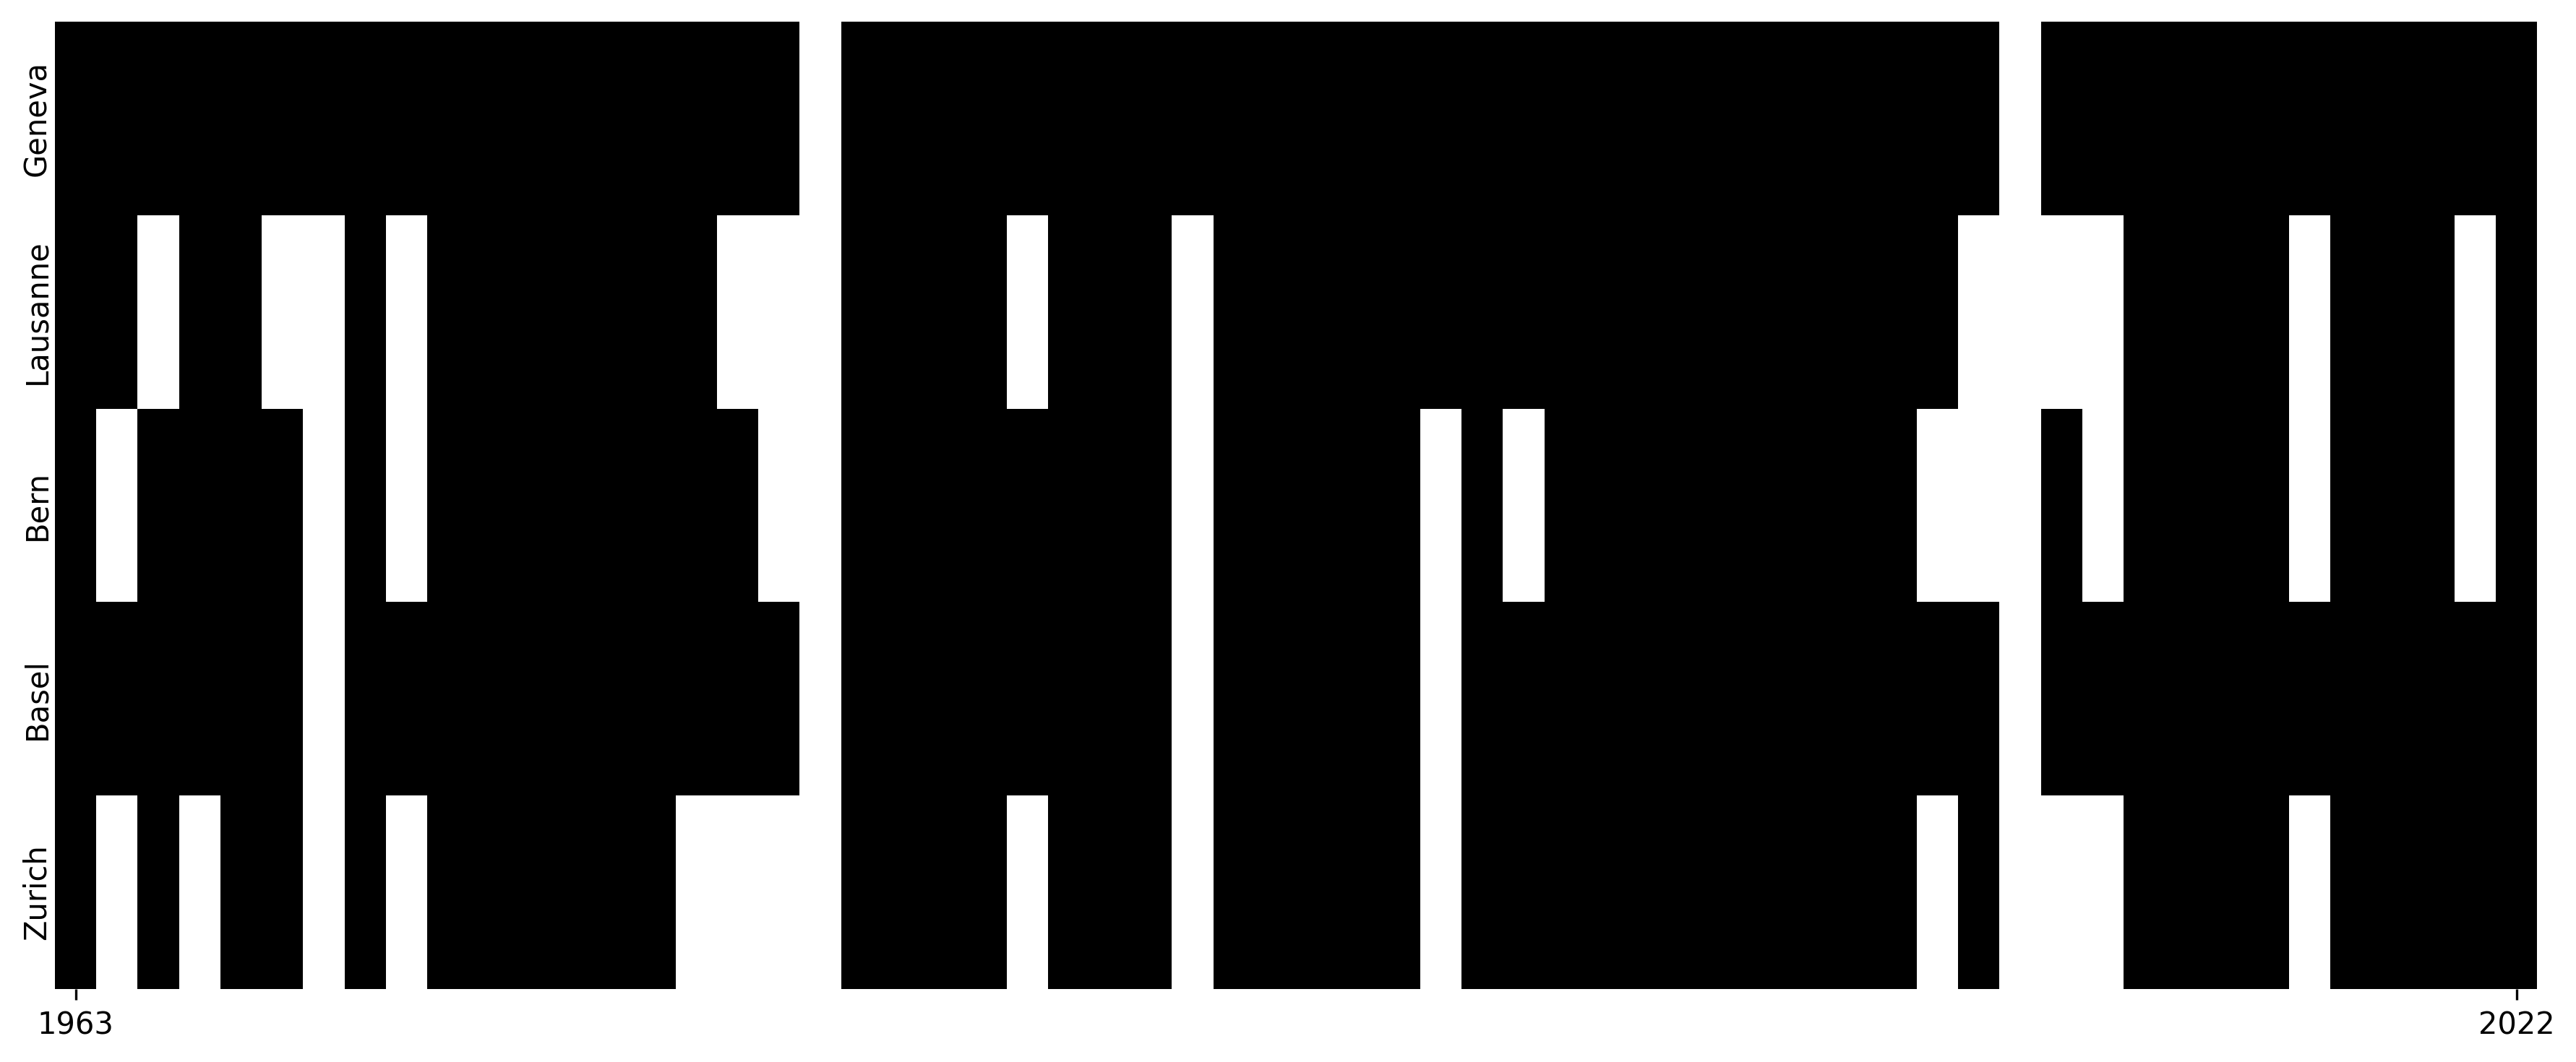

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# Example inputs (replace these with your actual datasets and city names)
datasets = [
    CH_SD_geneva_christmas.HSCLQMD,
    CH_SD_lausanne_christmas.HSCLQMD,
    CH_SD_bern_christmas.HSCLQMD,
    CH_SD_basel_christmas.HSCLQMD,
    CH_SD_zurich_christmas.HSCLQMD,
    # Add more datasets as needed
]

city_names = [
    "Geneva",
    "Lausanne",
    "Bern",
    "Basel",
    "Zurich",
    # Add more names corresponding to datasets
]

n = len(datasets)
if len(city_names) != n:
    raise ValueError("datasets and city_names must be the same length")

fig = plt.figure(figsize=(12, n), dpi=300)  # Height scales with number of plots

gs = gridspec.GridSpec(nrows=n, ncols=1, height_ratios=[1]*n, hspace=0)

for i in range(n):
    ax = fig.add_subplot(gs[i])
    
    data_array = datasets[i]
    data_reshaped = data_array.values.reshape(1, -1)
    
    sns.heatmap(data_reshaped, cmap="binary_r", cbar=False,
                xticklabels=False, yticklabels=False, ax=ax)
    
    ax.set_ylabel(city_names[i], rotation=90, ha='center', va='center', fontsize=10, labelpad=6)
    
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    if i == n - 1:
        ax.set_xticks([0.5, data_reshaped.shape[1] - 0.5])
        ax.set_xticklabels([
            data_array.time.dt.year.values[0],
            data_array.time.dt.year.values[-1]
        ])
    else:
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.tight_layout()
plt.savefig(plot_folder + "city_christmas_stacked.png")
plt.savefig(plot_folder + "city_christmas_stacked.pdf")
plt.show()


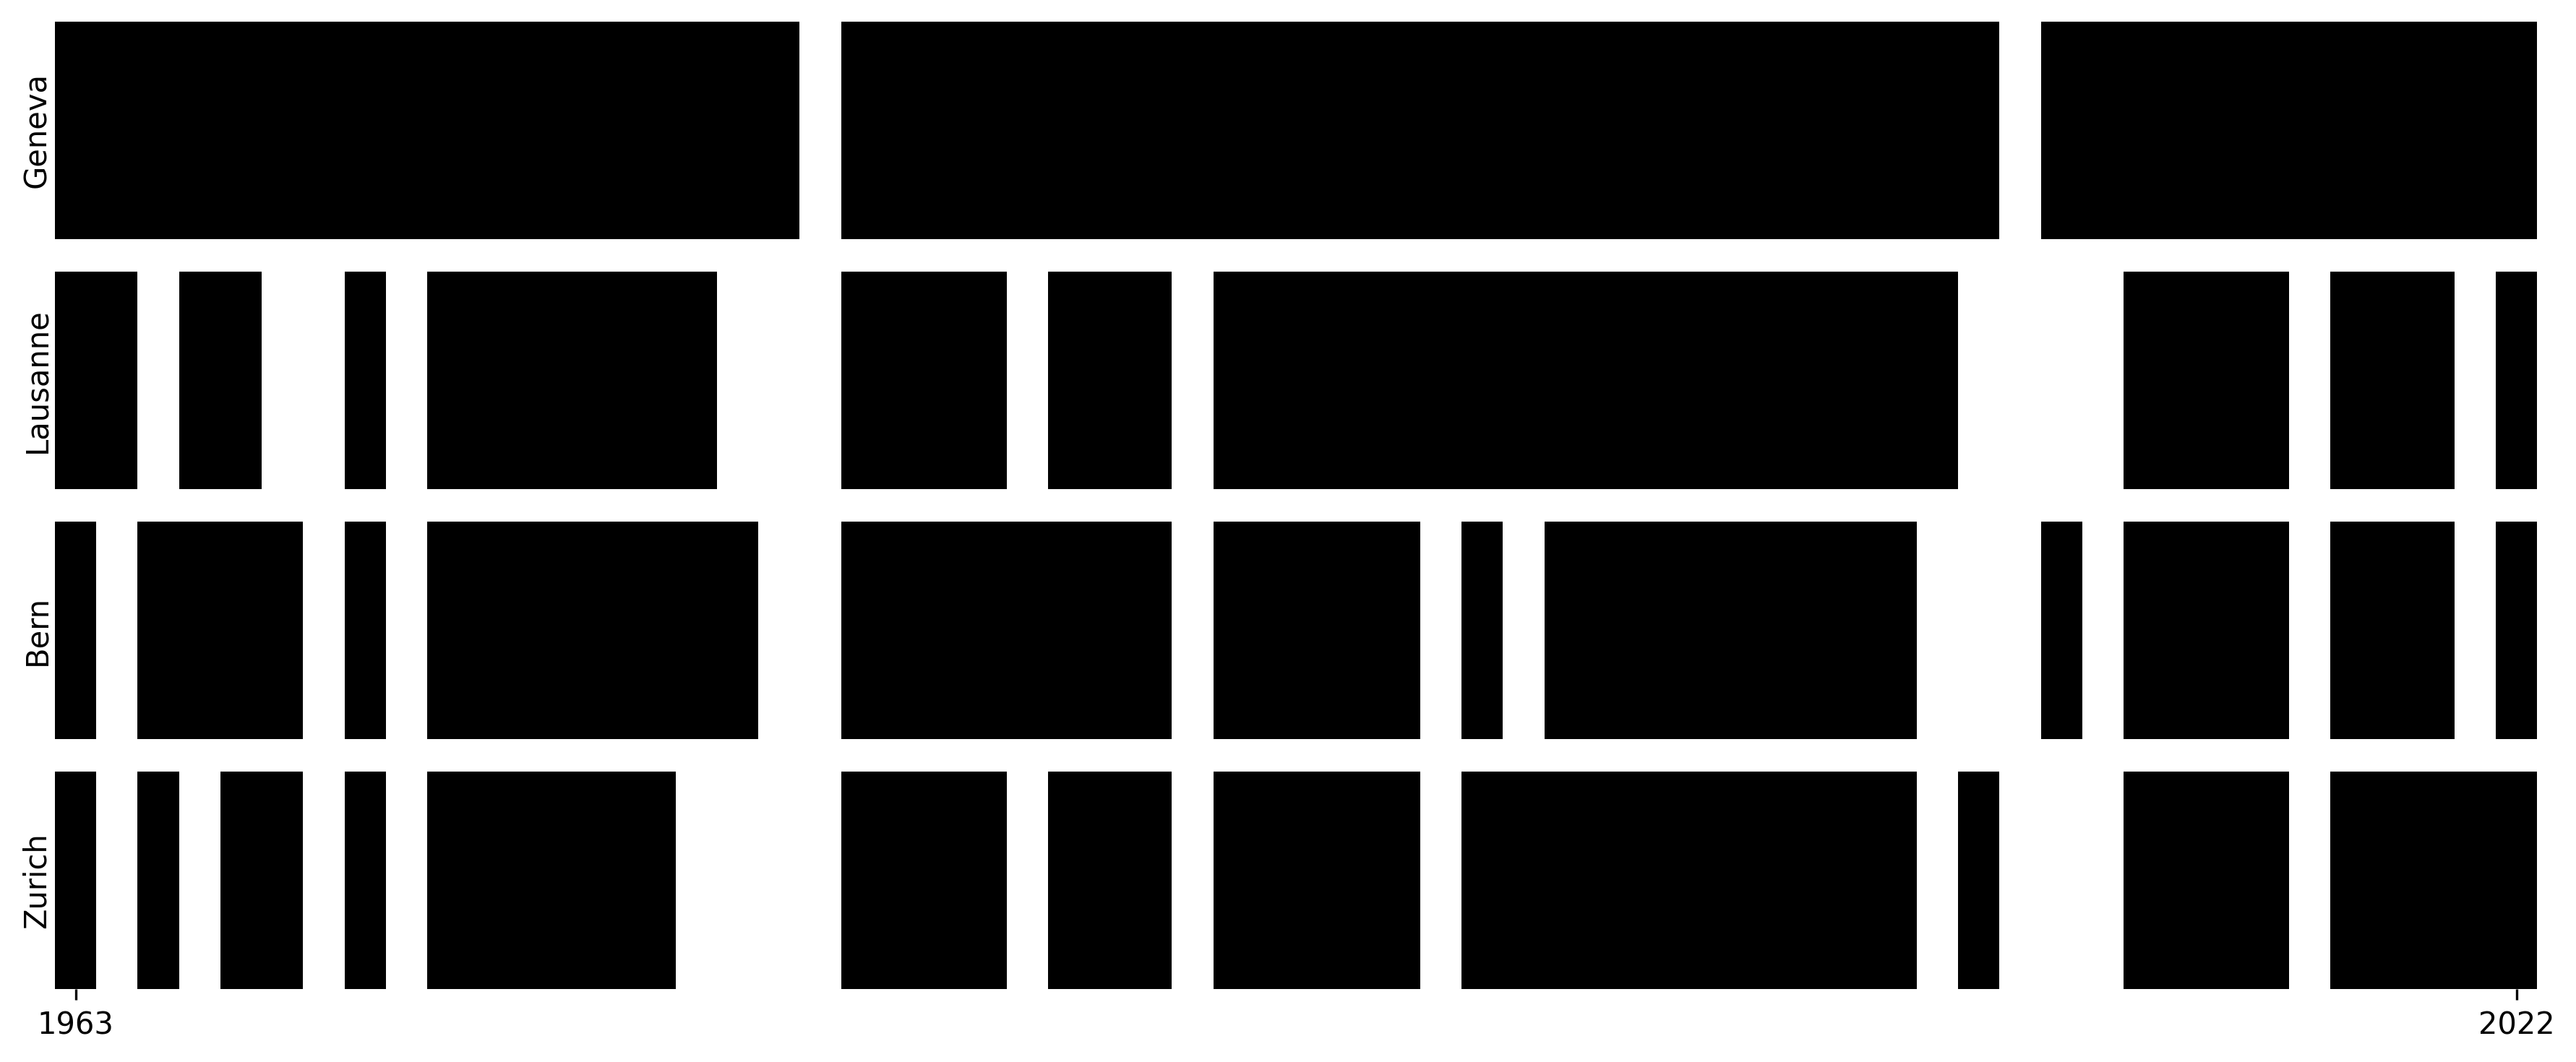

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example list of xarray DataArrays
datasets = [
    CH_SD_geneva_christmas.HSCLQMD,
    CH_SD_lausanne_christmas.HSCLQMD,
    CH_SD_bern_christmas.HSCLQMD,
    CH_SD_zurich_christmas.HSCLQMD
]

# Corresponding city names
city_names = ["Geneva", "Lausanne", "Bern", "Zurich"]

# Create figure with 4 subplots
fig, axes = plt.subplots(nrows=4, figsize=(12, 5), dpi=300, sharex=True)

# Loop through datasets and axes
for i, (data_array, ax) in enumerate(zip(datasets, axes)):
    # Reshape to 2D: 1 row x N columns
    data_reshaped = data_array.values.reshape(1, -1)
    
    # Plot the heatmap
    sns.heatmap(data_reshaped, cmap="binary_r", cbar=False,
                xticklabels=False, yticklabels=False, ax=ax)
    
    # Set y-axis label to the city name
    ax.set_ylabel(city_names[i], rotation=90, ha='center', va='center', fontsize=10, labelpad=6)
    
    # Hide spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Only show x-axis ticks on the bottom plot
    if i == len(datasets) - 1:
        ax.set_xticks([0.5, data_reshaped.shape[1] - 0.5])
        ax.set_xticklabels([
            data_array.time.dt.year.values[0],
            data_array.time.dt.year.values[-1]
        ])
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Adjust layout to remove vertical space
plt.subplots_adjust(hspace=0)
plt.tight_layout()


plt.savefig(plot_folder + "city_christmas_stacked_gap.png")
plt.savefig(plot_folder + "city_christmas_stacked_gap.pdf")
plt.show()

## Record low year for ski season

## Monthly heatmap

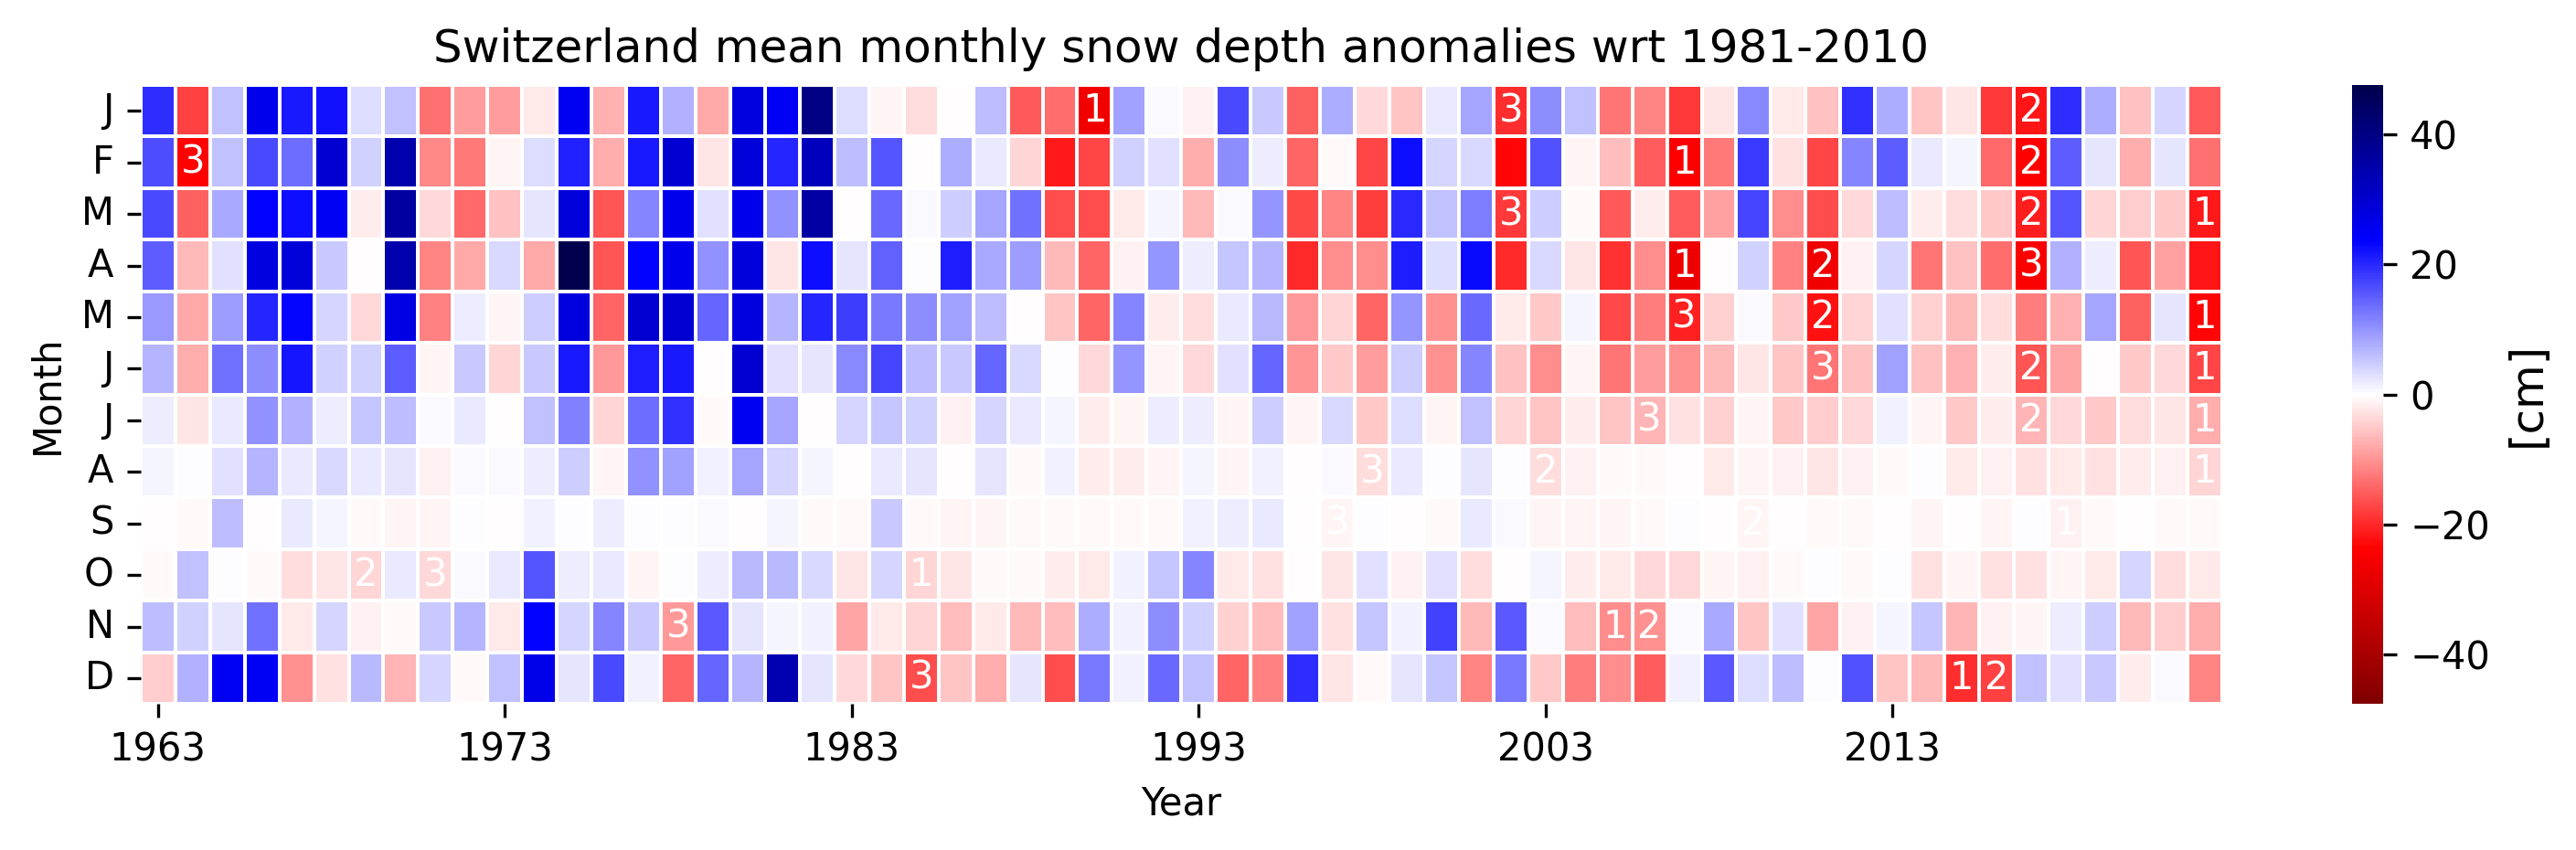

In [43]:
plotting_ranked_heatmap(data=CH_SD_mon_fieldmean_ext,variable="HSCLQMD",plot_folder=plot_folder,cmap="seismic_r",ranked_pos=False)

## climate stripes over CH

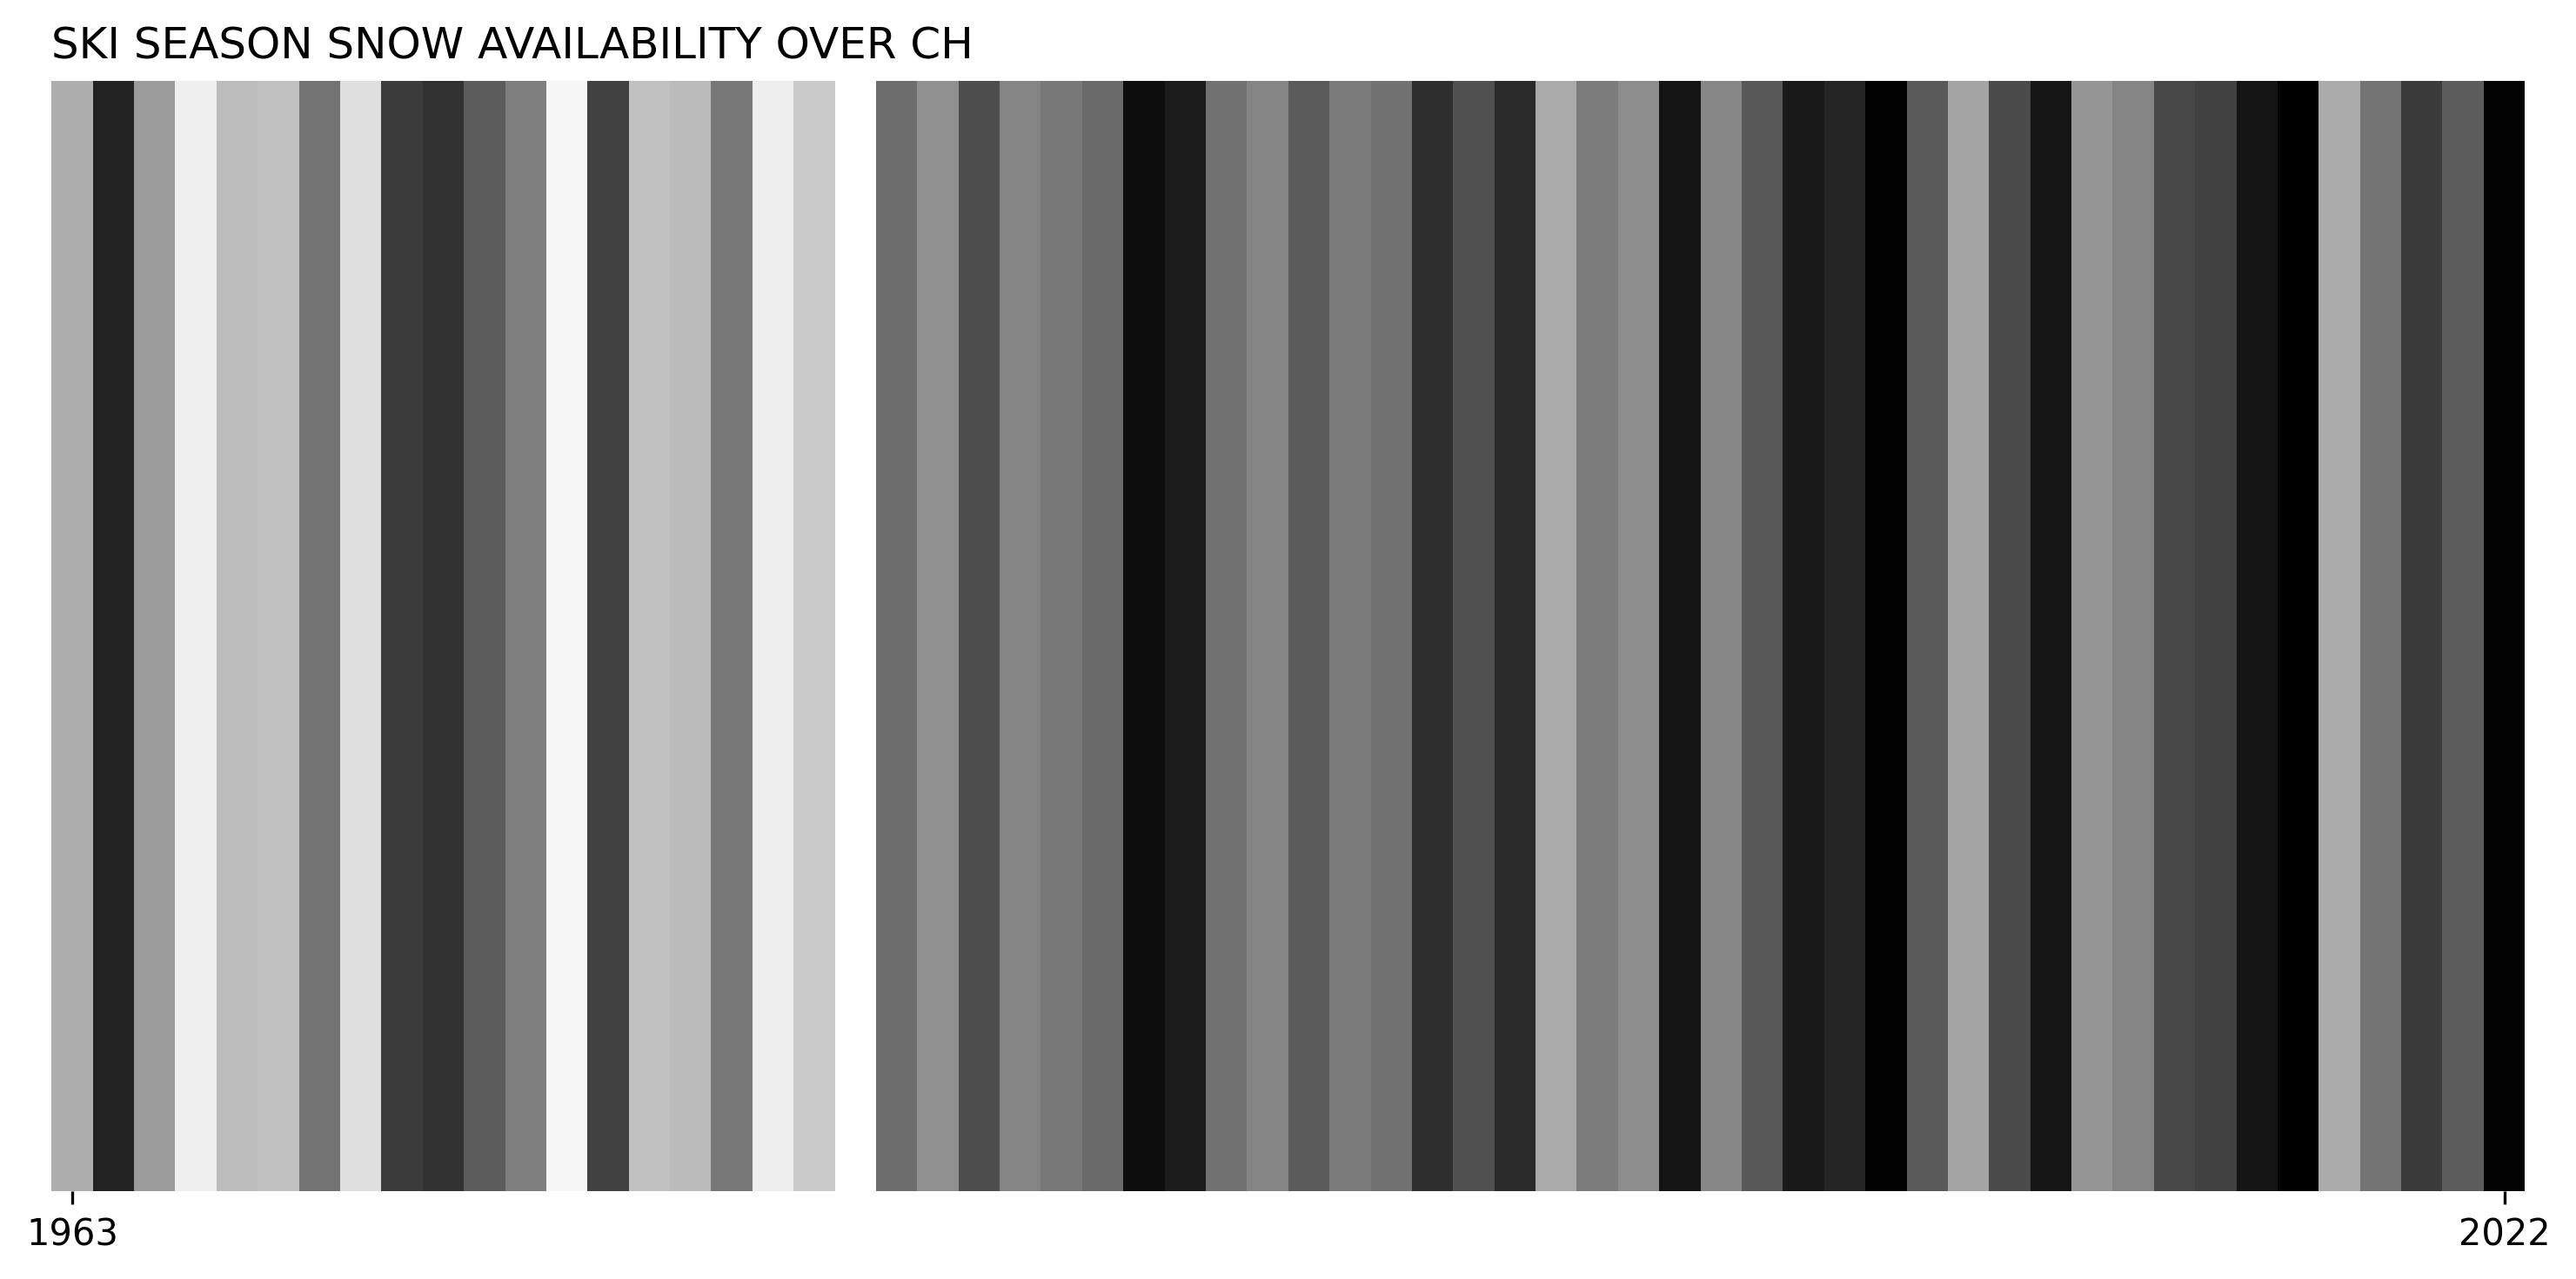

In [44]:
# Reshape data to 2D for heatmap (as a 1xN array)
data_reshaped = mean_dec_to_may_fldmean.HSCLQMD.values.reshape(1, -1)

# Create the heatmap
#plt.figure(figsize=(12, 4))  # Adjust the size for a narrow strip-like appearance
fig, axs = plt.subplots(1, 1, figsize=(10, 5), dpi= 300)
sns.heatmap(data_reshaped, cmap="binary_r", cbar=False, xticklabels=False, yticklabels=False)

# Calculate the positions for the ticks
middle_start = data_reshaped.shape[1] // 10  # Position a little towards the middle of the first column
middle_end = data_reshaped.shape[1] - (data_reshaped.shape[1] // 10)  # Position a little towards the middle of the last column
middle_start=0.5
middle_end=data_reshaped.shape[1]-0.5


# Set the x-axis ticks to be more in the center
axs.set_xticks([middle_start, middle_end])  # Set the positions of the labels (start and end)
axs.set_xticklabels([1963, 2022])  # Set the actual labels

# Remove axis labels for a cleaner look
plt.xlabel('')
plt.ylabel('')
plt.title("SKI SEASON SNOW AVAILABILITY OVER CH",loc="left")
#plt.title("@martin_wegmann",loc="right")

# Show the plot
plt.tight_layout()

plt.savefig(plot_folder+"CH_snow_stripes_white.png")
fig.savefig(plot_folder+"CH_snow_stripes_white.pdf")
plt.show()

## climate stripes over elevation bands

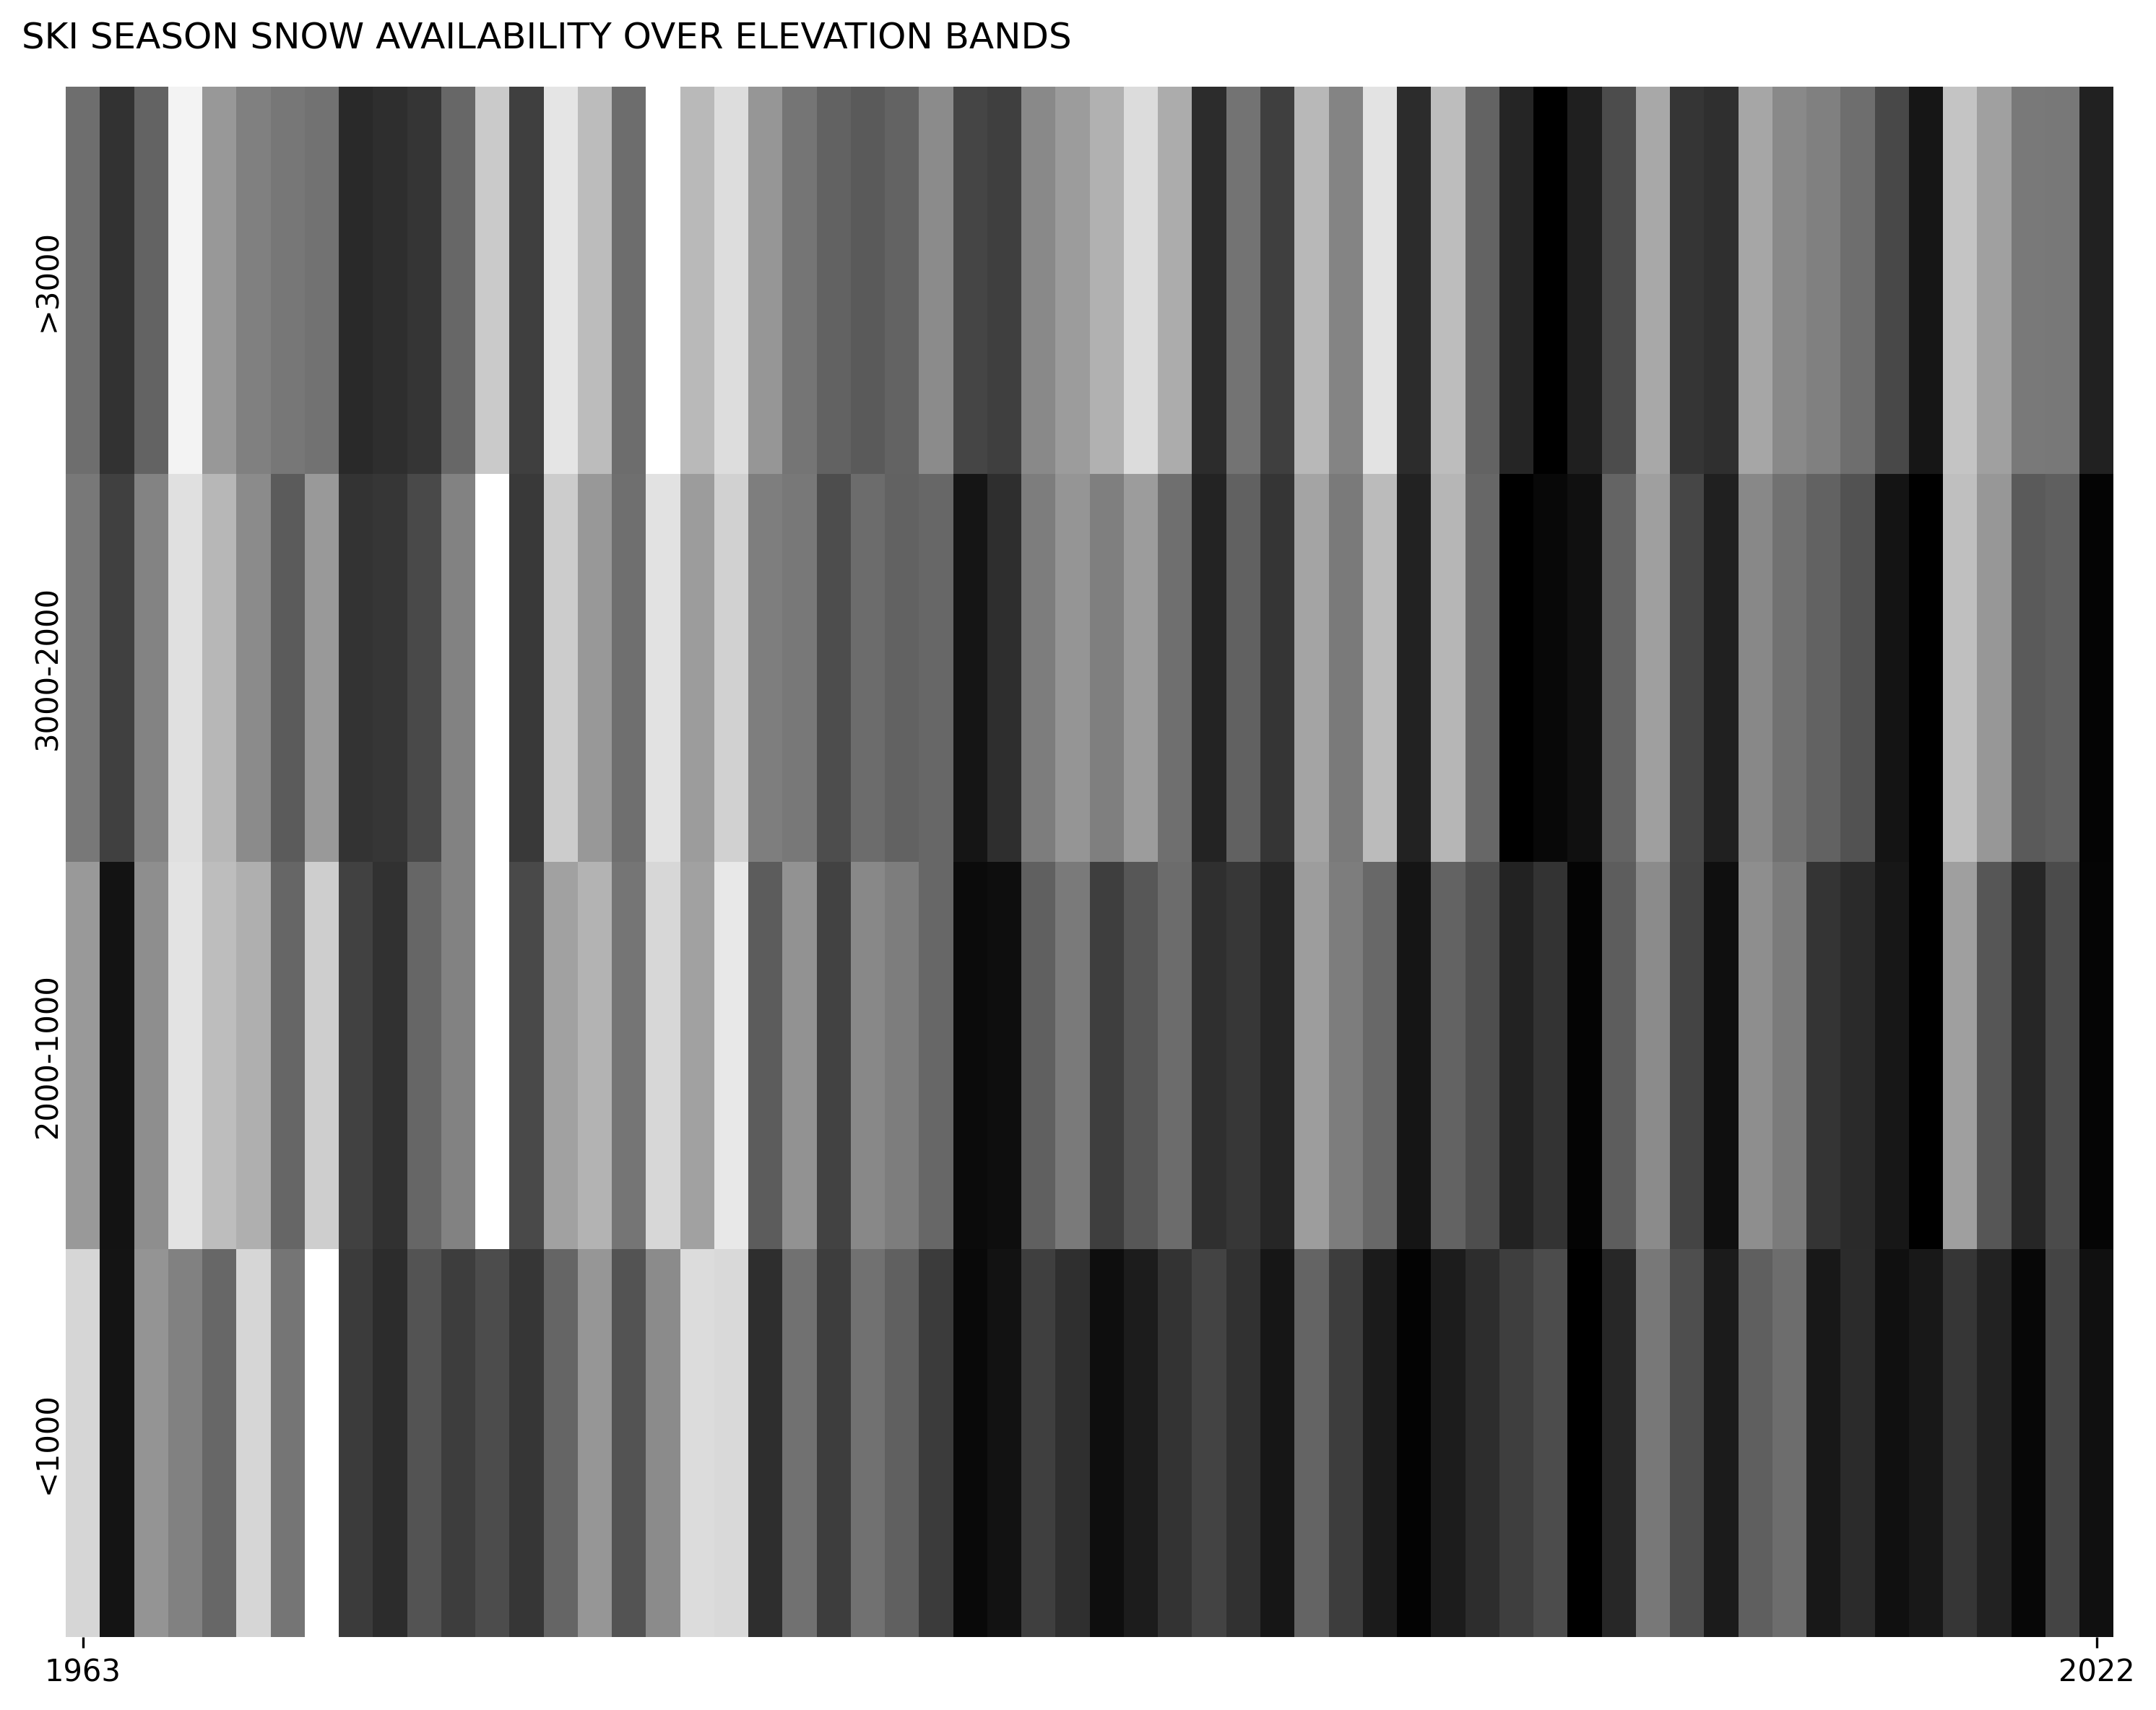

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec

# Assume each dataset spans the same years: 1974–2023
datasets = [
    masked_da2_3000_ym_fldmean.values,
    masked_da2_2000_ym_fldmean.values,
    masked_da2_1000_ym_fldmean.values,
    masked_da2_900_ym_fldmean.values,
]

city_names = [">3000", "3000-2000", "2000-1000", "<1000"]

# Create a figure and GridSpec layout with 5 rows
fig = plt.figure(figsize=(10, 8), dpi=300)
gs = gridspec.GridSpec(4, 1, height_ratios=[1] * 4, hspace=0)

# Loop through datasets and plot each as a heatmap row
for i, (data, name) in enumerate(zip(datasets, city_names)):
    ax = fig.add_subplot(gs[i])
    
    # Reshape to 2D: 1 row x N columns
    data_reshaped = data.reshape(1, -1)
    
    sns.heatmap(
        data_reshaped,
        cmap="binary_r",
        cbar=False,
        xticklabels=False,
        yticklabels=False,
        ax=ax
    )

    # X-axis ticks only on bottom row
    if i == len(datasets) - 1:
        ax.set_xticks([0.5, data_reshaped.shape[1] - 0.5])
        ax.set_xticklabels([1963, 2022])
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])

    # Add city name as y-axis label
    ax.set_ylabel(name, rotation=90, ha='center', va='center', fontsize=10, labelpad=6)

    # Remove default axis labels
    ax.set_xlabel('')

# Add title and credits
fig.suptitle("SKI SEASON SNOW AVAILABILITY OVER ELEVATION BANDS", x=0.01, ha='left', fontsize=12)
#fig.text(0.99, 0.97, "@martin_wegmann", ha='right', fontsize=10)

# Adjust layout
plt.subplots_adjust(left=0.02, right=0.99, top=0.95, bottom=0.05)

plt.tight_layout()

plt.savefig(plot_folder+"CH_snow_stripes_elevation_white.png")
fig.savefig(plot_folder+"CH_snow_stripes_elevation_white.pdf")
plt.show()

## climate stripes ski resorts

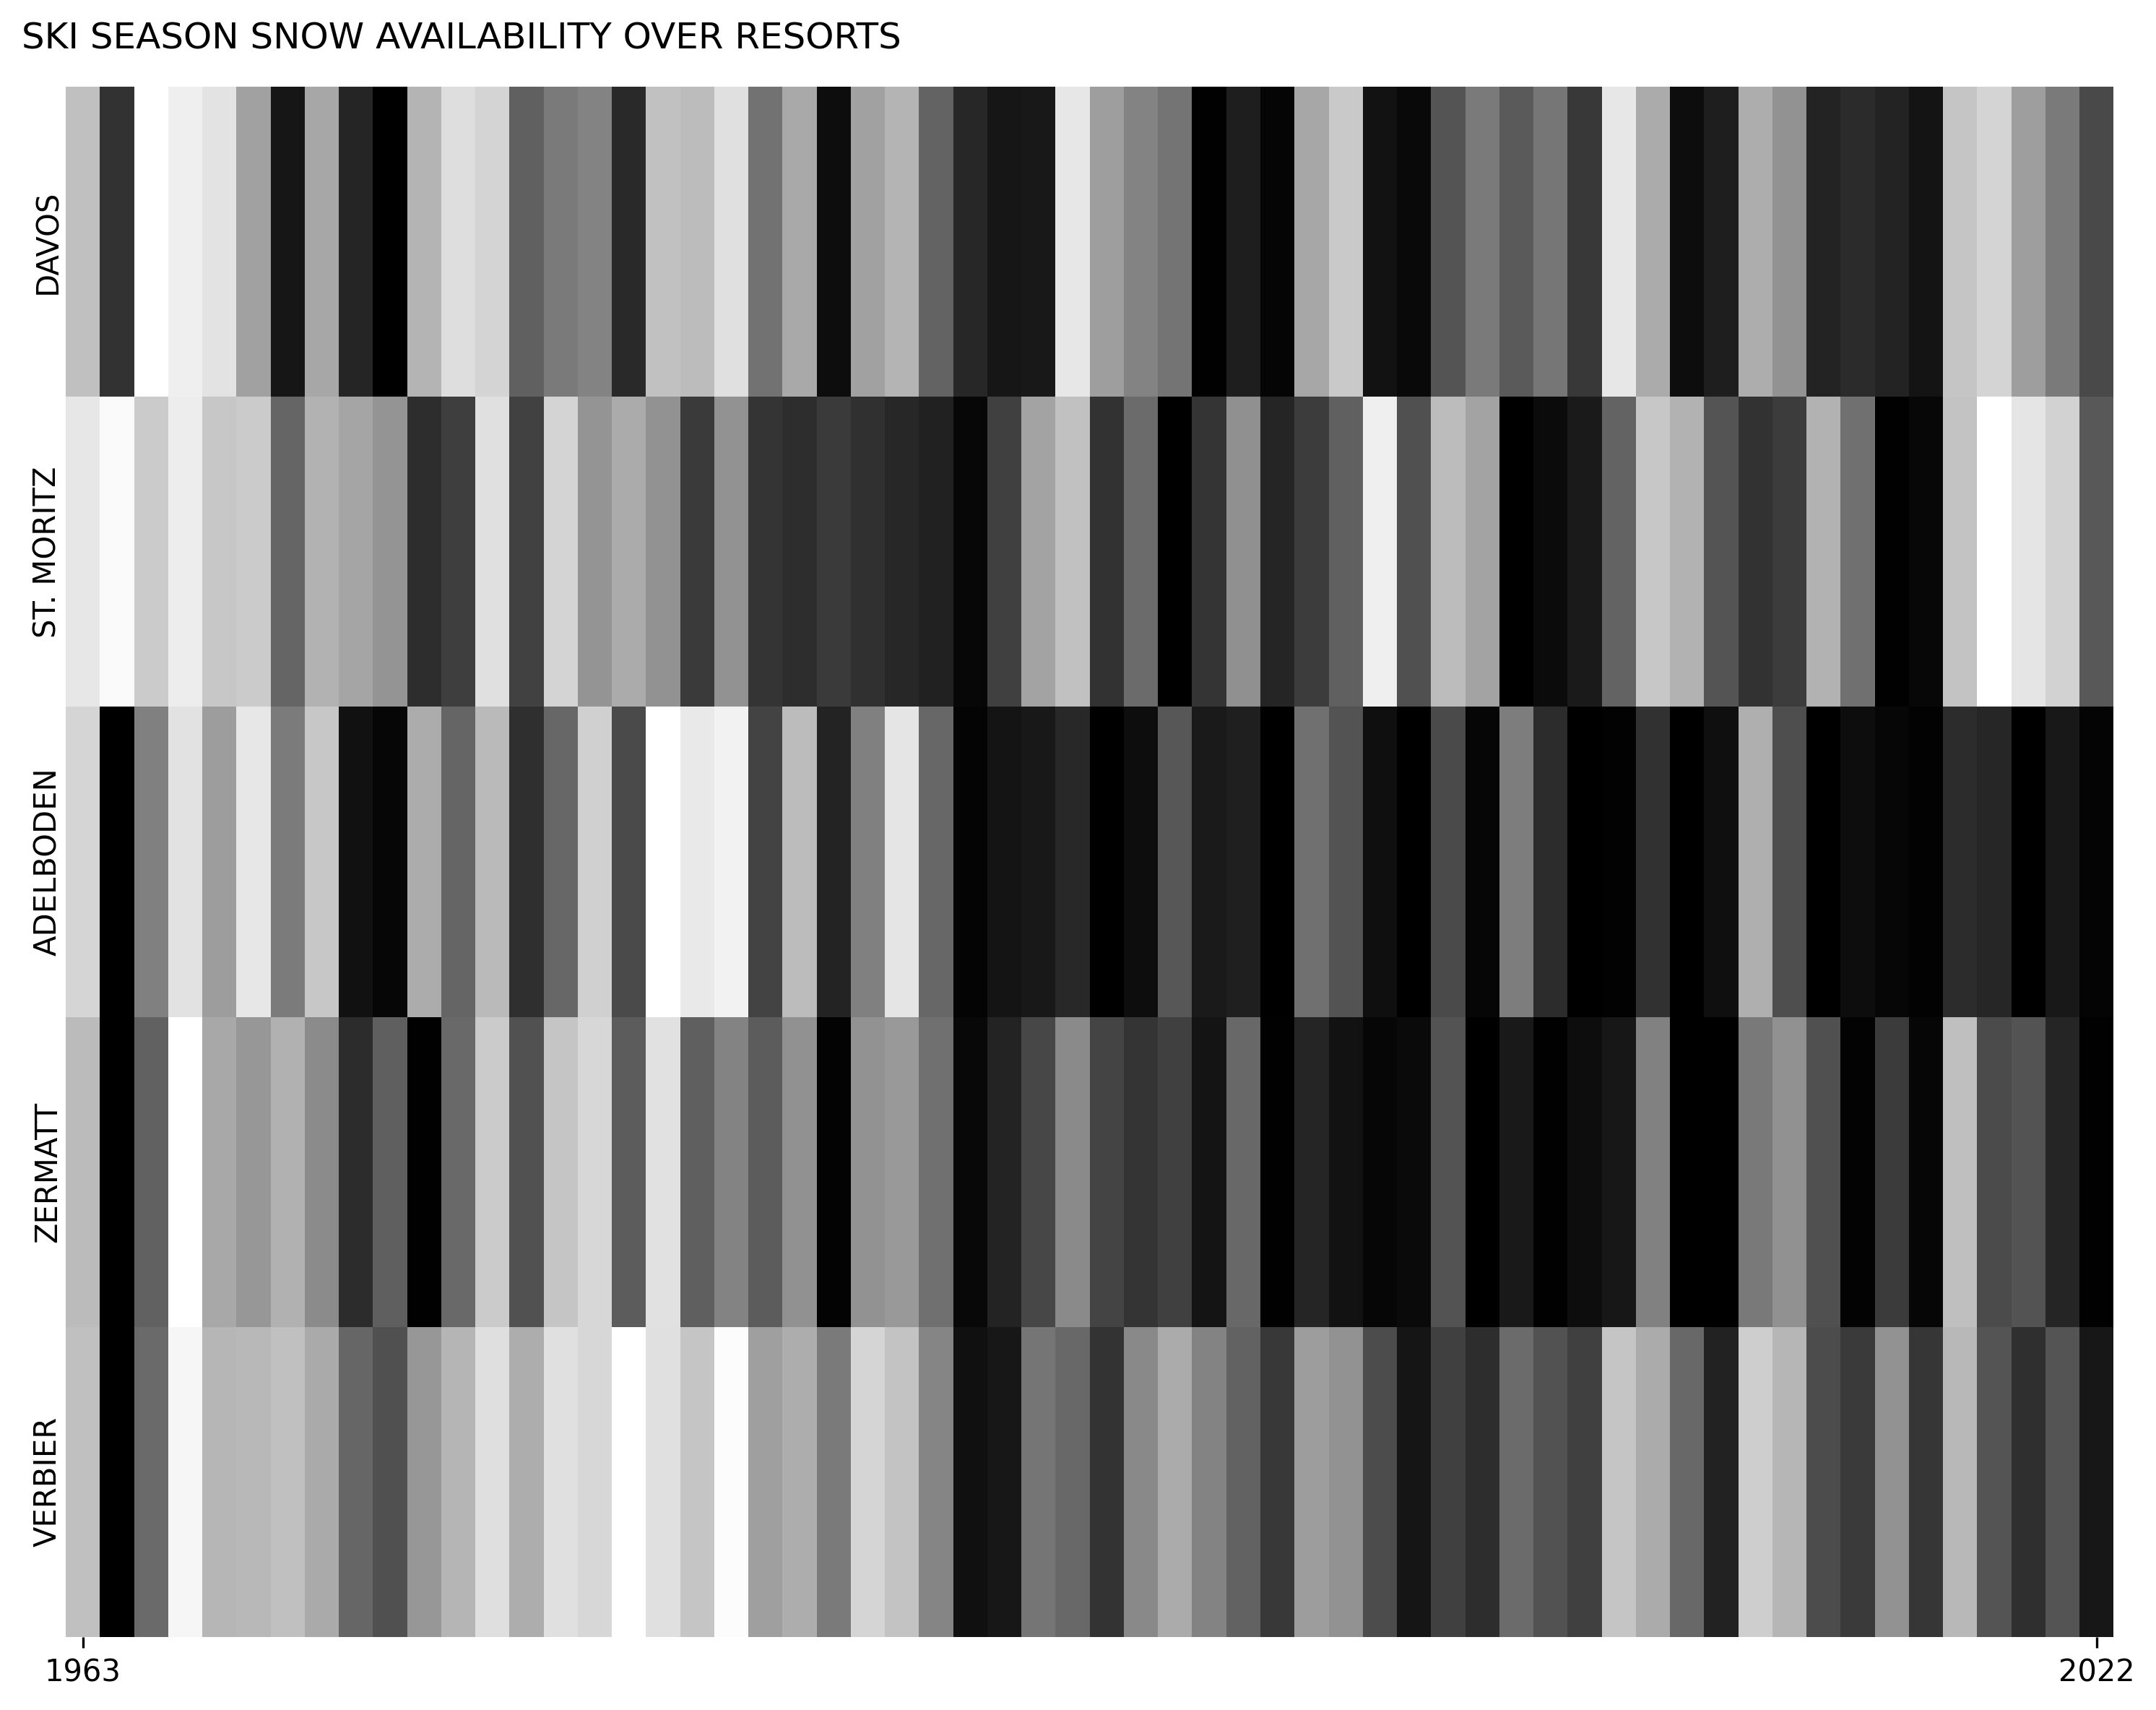

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec

# Assume each dataset spans the same years: 1974–2023
datasets = [
    CH_SD_davos_onem.values,
    CH_SD_stmoritz_onem.values,
    CH_SD_adelboden_onem.values,
    CH_SD_zermatt_onem.values,
    CH_SD_verbier_onem.values
]

city_names = ["DAVOS", "ST. MORITZ", "ADELBODEN", "ZERMATT", "VERBIER"]

# Create a figure and GridSpec layout with 5 rows
fig = plt.figure(figsize=(10, 8), dpi=300)
gs = gridspec.GridSpec(5, 1, height_ratios=[1] * 5, hspace=0)

# Loop through datasets and plot each as a heatmap row
for i, (data, name) in enumerate(zip(datasets, city_names)):
    ax = fig.add_subplot(gs[i])
    
    # Reshape to 2D: 1 row x N columns
    data_reshaped = data.reshape(1, -1)
    
    sns.heatmap(
        data_reshaped,
        cmap="binary_r",
        cbar=False,
        xticklabels=False,
        yticklabels=False,
        ax=ax
    )

    # X-axis ticks only on bottom row
    if i == len(datasets) - 1:
        ax.set_xticks([0.5, data_reshaped.shape[1] - 0.5])
        ax.set_xticklabels([1963, 2022])
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])

    # Add city name as y-axis label
    ax.set_ylabel(name, rotation=90, ha='center', va='center', fontsize=10, labelpad=6)

    # Remove default axis labels
    ax.set_xlabel('')

# Add title and credits
fig.suptitle("SKI SEASON SNOW AVAILABILITY OVER RESORTS", x=0.01, ha='left', fontsize=12)
#fig.text(0.99, 0.97, "@martin_wegmann", ha='right', fontsize=10)

# Adjust layout
plt.subplots_adjust(left=0.02, right=0.99, top=0.95, bottom=0.05)

plt.tight_layout()

plt.savefig(plot_folder+"CH_snow_stripes_resorts_white.png")
fig.savefig(plot_folder+"CH_snow_stripes_resorts_white.pdf")
plt.show()

## spatial anomalies time series ski season

(60, 265, 370)
Stored in /Volumes/SPARK3/meteo_swiss/snow/plots/HSCLQMD_winter_anoms.png


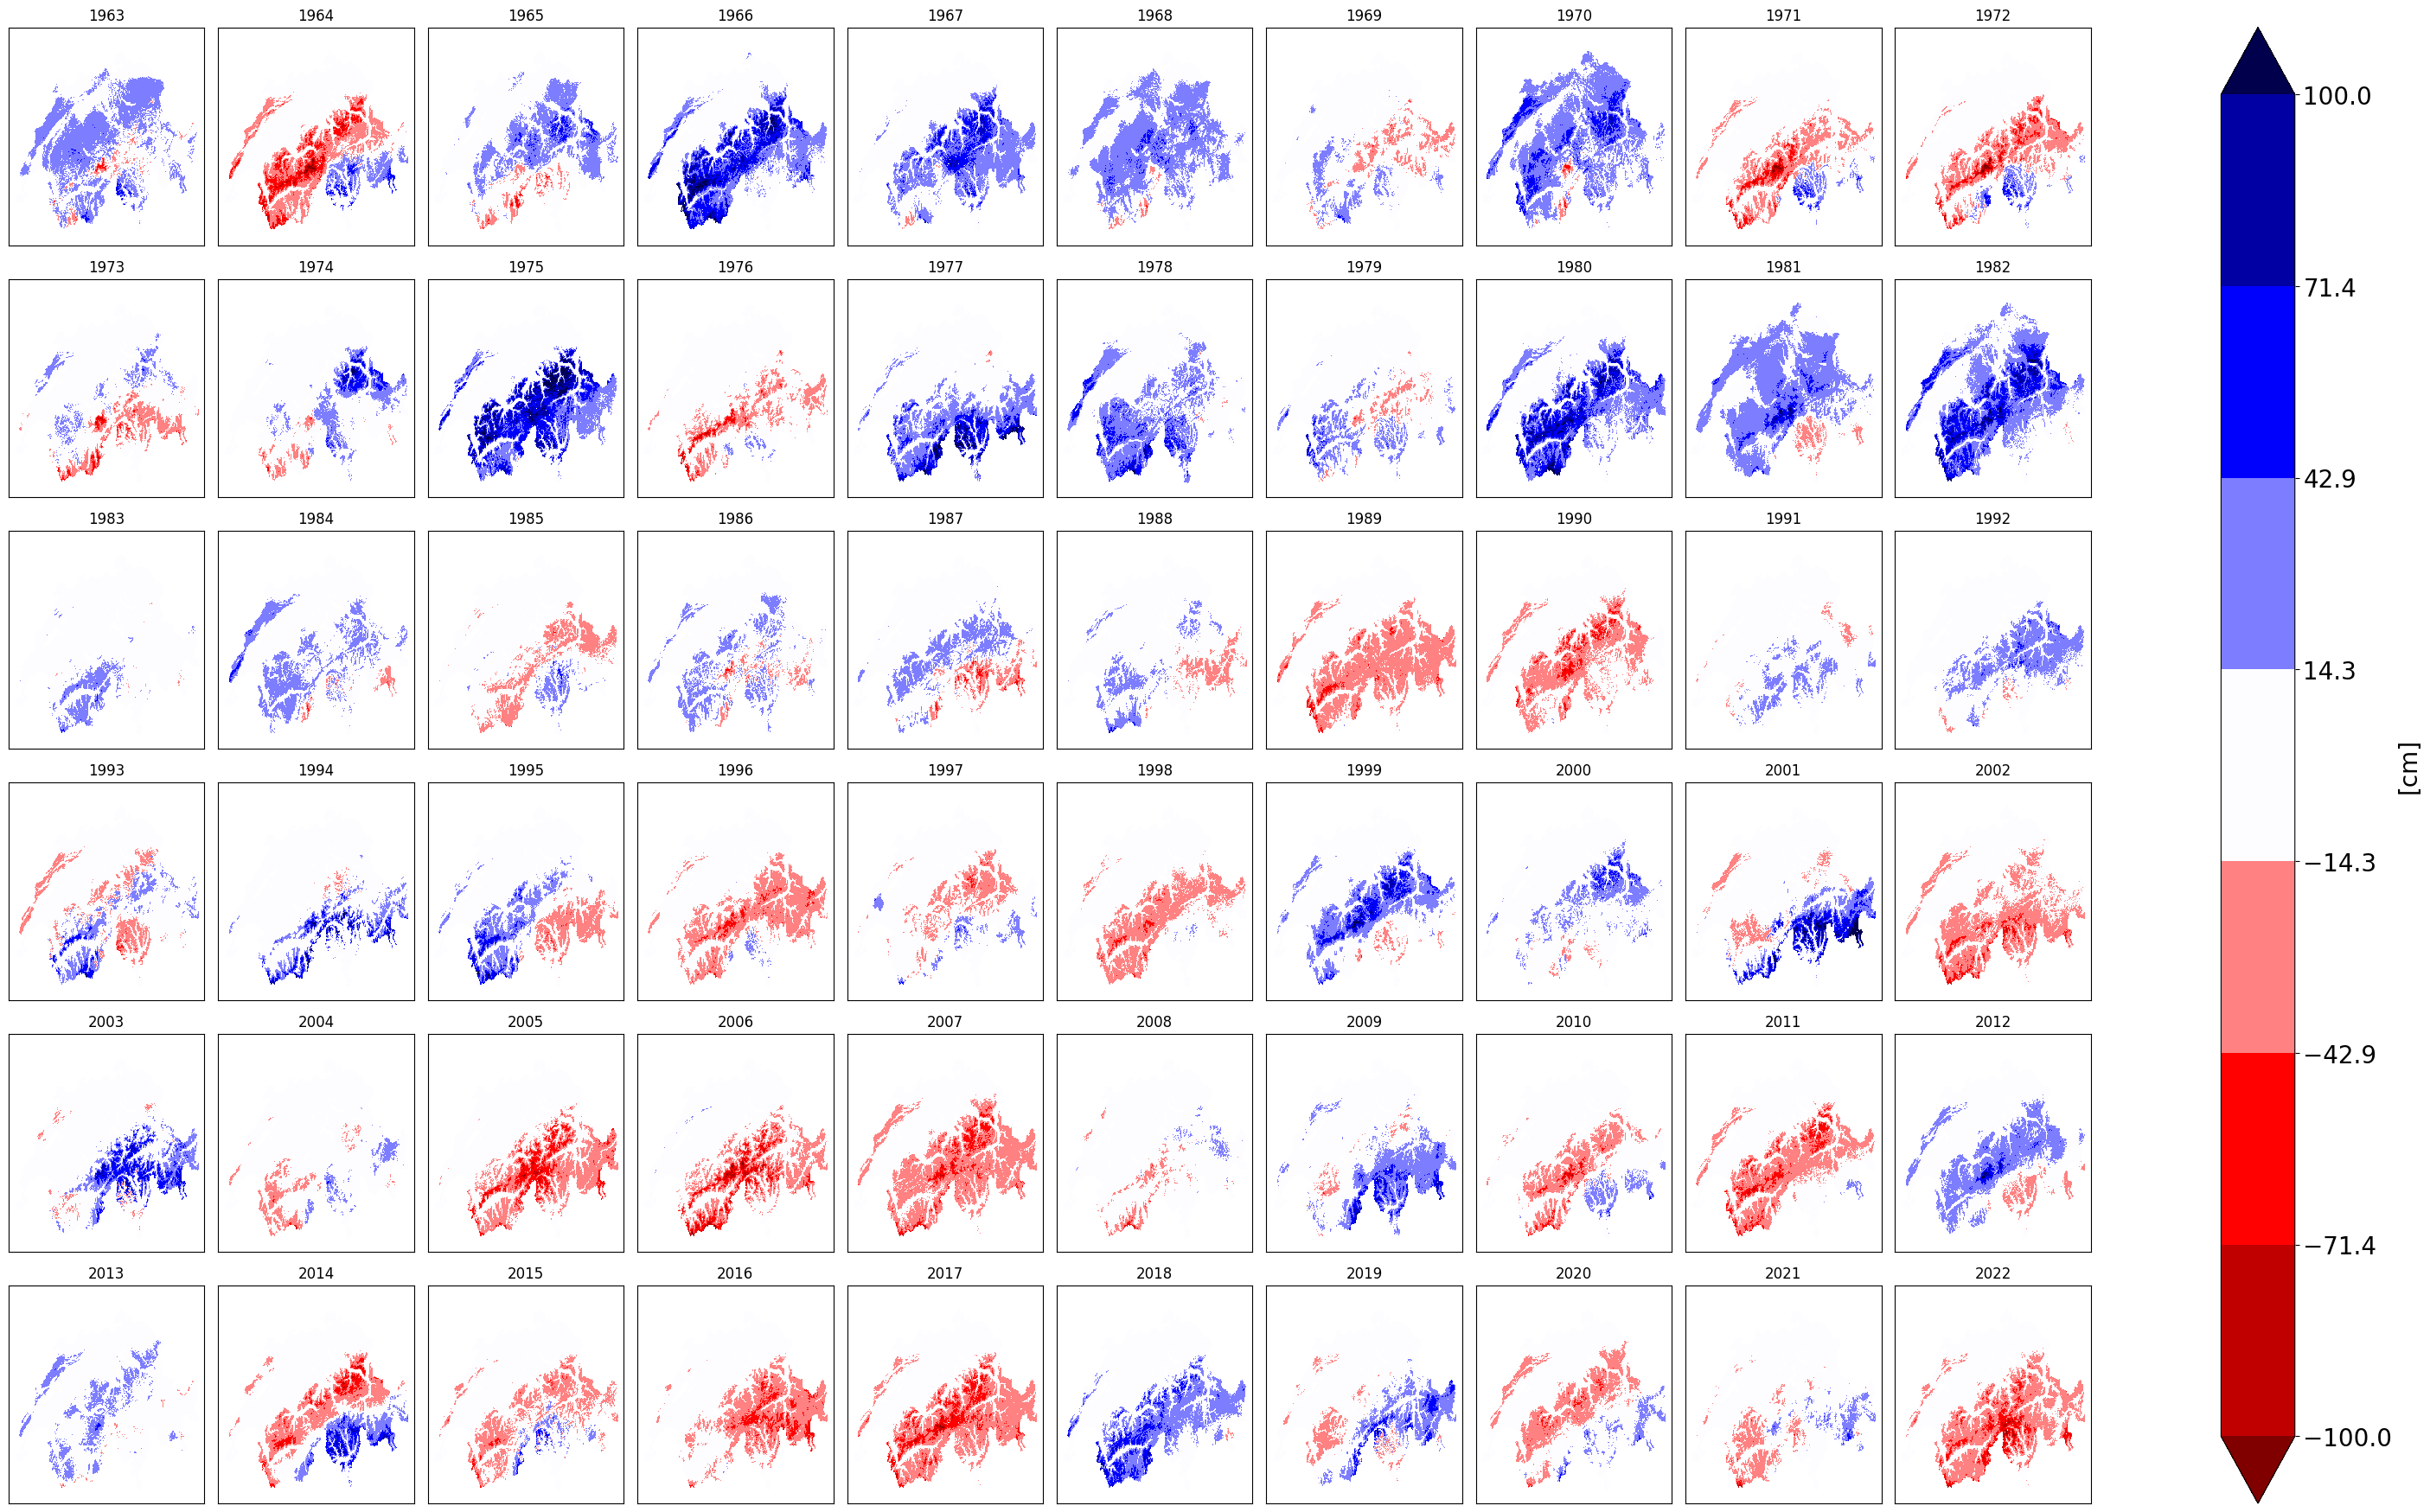

In [47]:
data=mean_dec_to_may
data_clim=data.sel(year=(slice("1981","2010"))).mean(dim="year")
data_anoms=data-data_clim

plot_anom_ts_2d(data=data_anoms,var="HSCLQMD",plot_folder=plot_folder,cmap="seismic_r",resolution="winter",ncols=10)

## trend ski seasons

In [48]:
trend = mean_dec_to_may.HSCLQMD.polyfit(dim = "year", deg = 1)

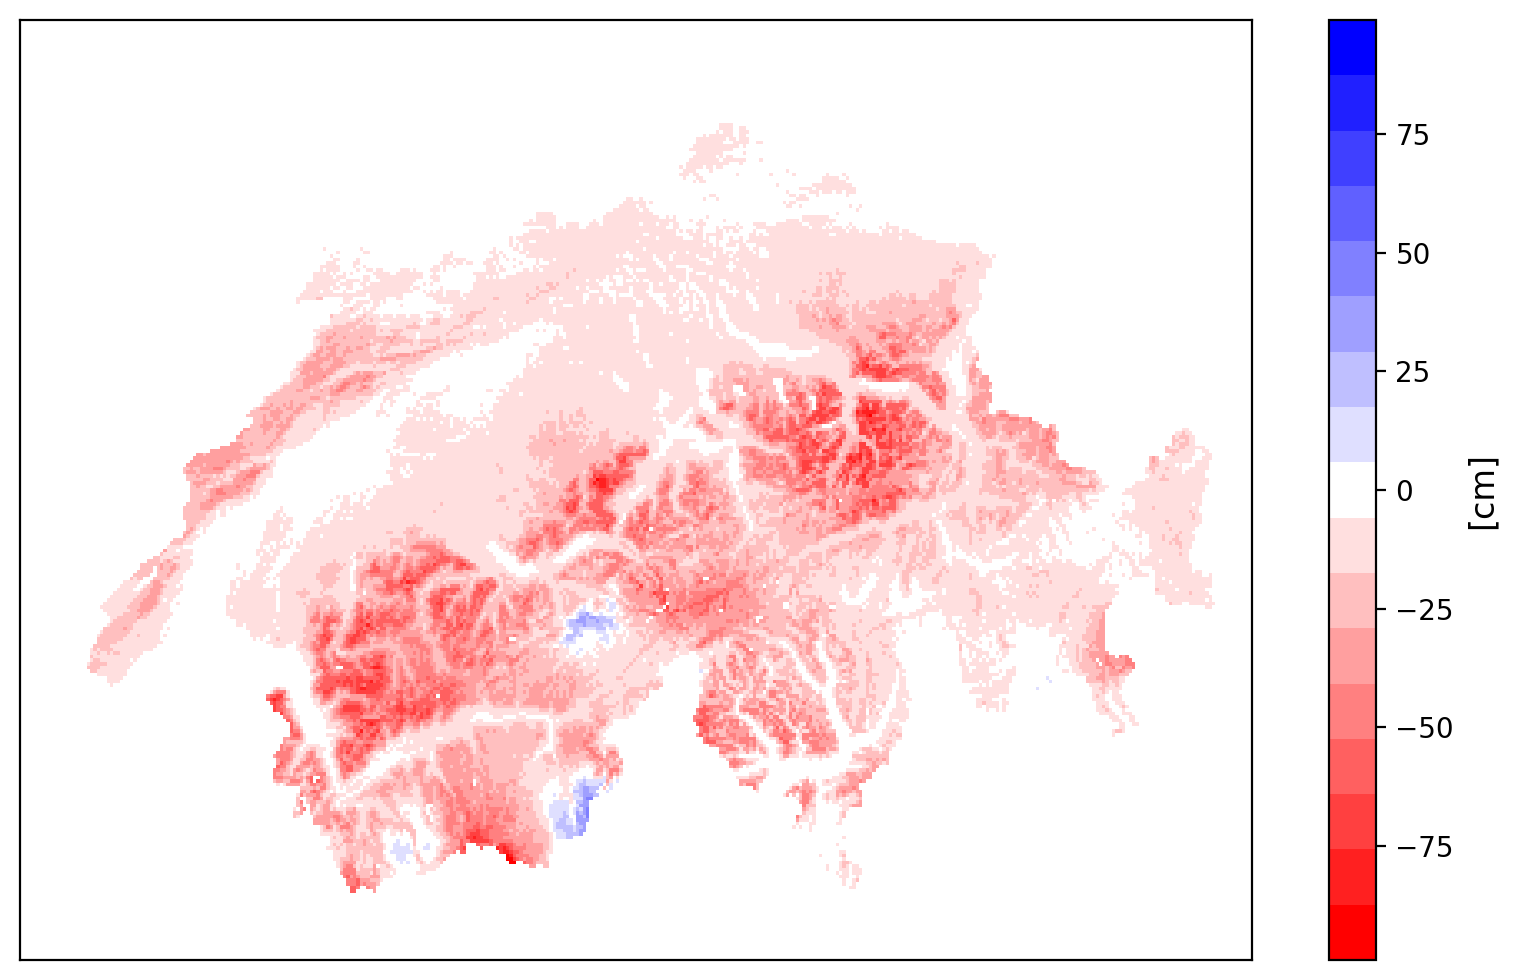

In [49]:
fig = plt.figure(figsize=(8, 5), dpi= 200)
ax = plt.gca()

trend_60=trend.sel(degree=1).polyfit_coefficients*60

mesh=trend_60.plot.pcolormesh(cmap=bwr_custom)
cbar = mesh.colorbar  # Access the colorbar associated with the QuadMesh

ax.set_xlabel('')
ax.set_ylabel('')
plt.title("")

# Optionally: hide tick labels too
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(
    axis='both',        # Apply to both x and y axis
    which='both',       # Major and minor ticks
    bottom=False,       # Remove bottom ticks
    top=False,          # Remove top ticks
    left=False,         # Remove left ticks
    right=False,        # Remove right ticks
    labelbottom=False,  # Remove x-axis tick labels
    labelleft=False     # Remove y-axis tick labels
)
cbar.set_label('[cm]', fontsize=12)

#plt.grid()
#ax.set_xticks([])
#ax.set_yticks([])
plt.tight_layout()

plt.savefig(plot_folder + "trend_white.png")
plt.savefig(plot_folder + "trend_white.pdf")
plt.show()

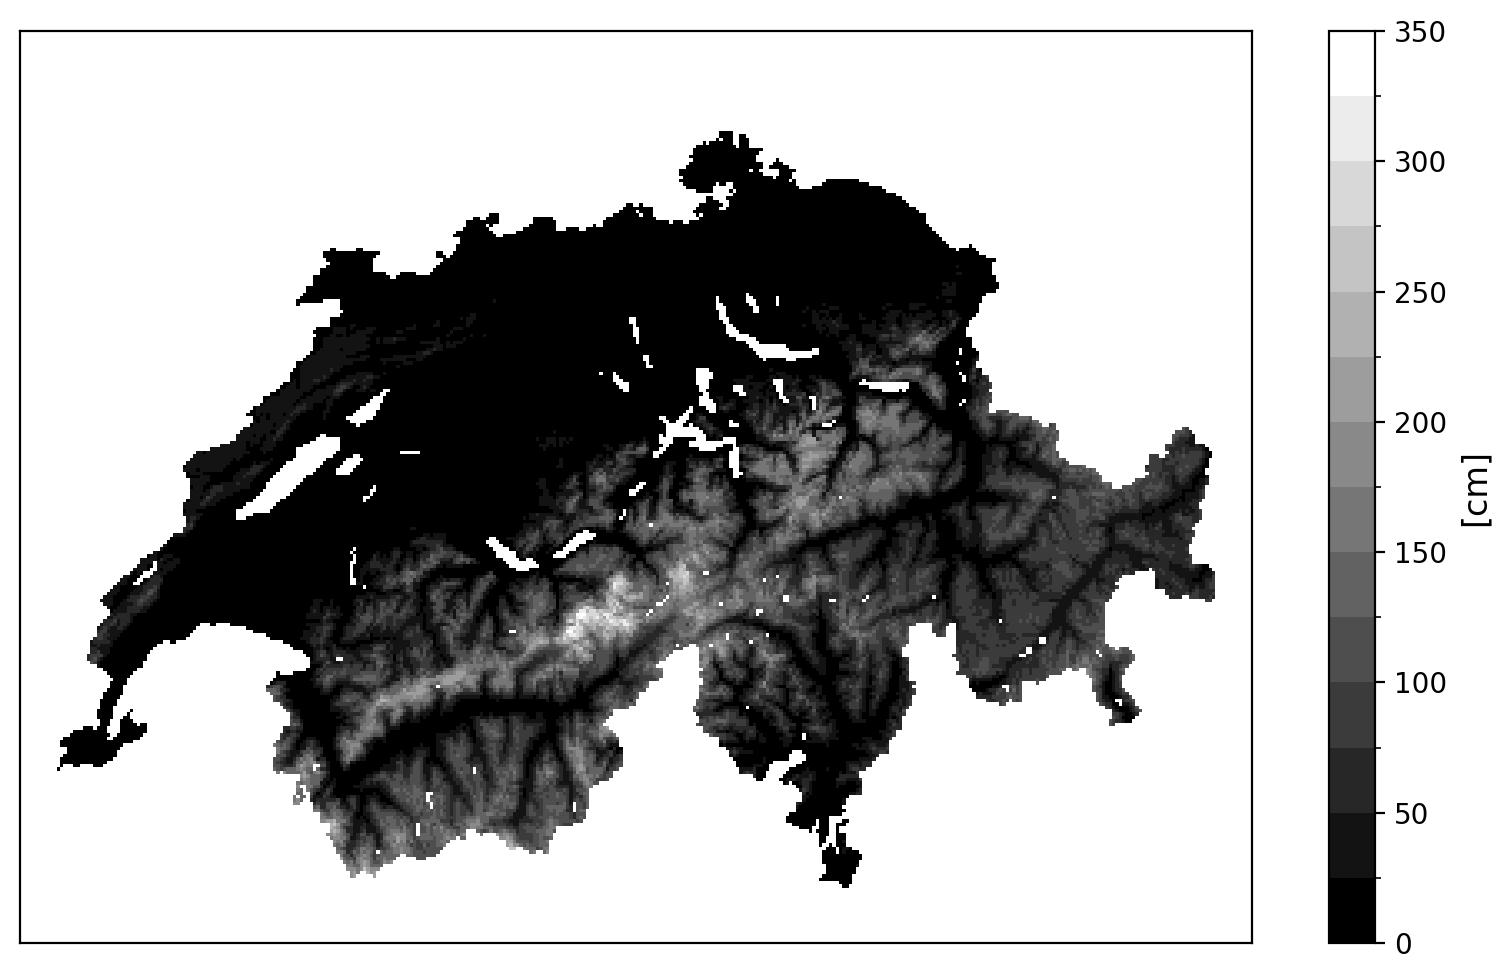

In [50]:
fig = plt.figure(figsize=(8, 5), dpi= 200)
ax = plt.gca()


mesh=mean_dec_to_may.mean(dim="year").HSCLQMD.plot.pcolormesh(cmap="binary_r",levels = 17)
cbar = mesh.colorbar  # Access the colorbar associated with the QuadMesh

ax.set_xlabel('')
ax.set_ylabel('')
plt.title("")

# Optionally: hide tick labels too
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(
    axis='both',        # Apply to both x and y axis
    which='both',       # Major and minor ticks
    bottom=False,       # Remove bottom ticks
    top=False,          # Remove top ticks
    left=False,         # Remove left ticks
    right=False,        # Remove right ticks
    labelbottom=False,  # Remove x-axis tick labels
    labelleft=False     # Remove y-axis tick labels
)
cbar.set_label('[cm]', fontsize=12)

#plt.grid()
#ax.set_xticks([])
#ax.set_yticks([])
plt.tight_layout()

plt.savefig(plot_folder + "average_50years_white.png")
plt.savefig(plot_folder + "average_50years_white.pdf")
plt.show()

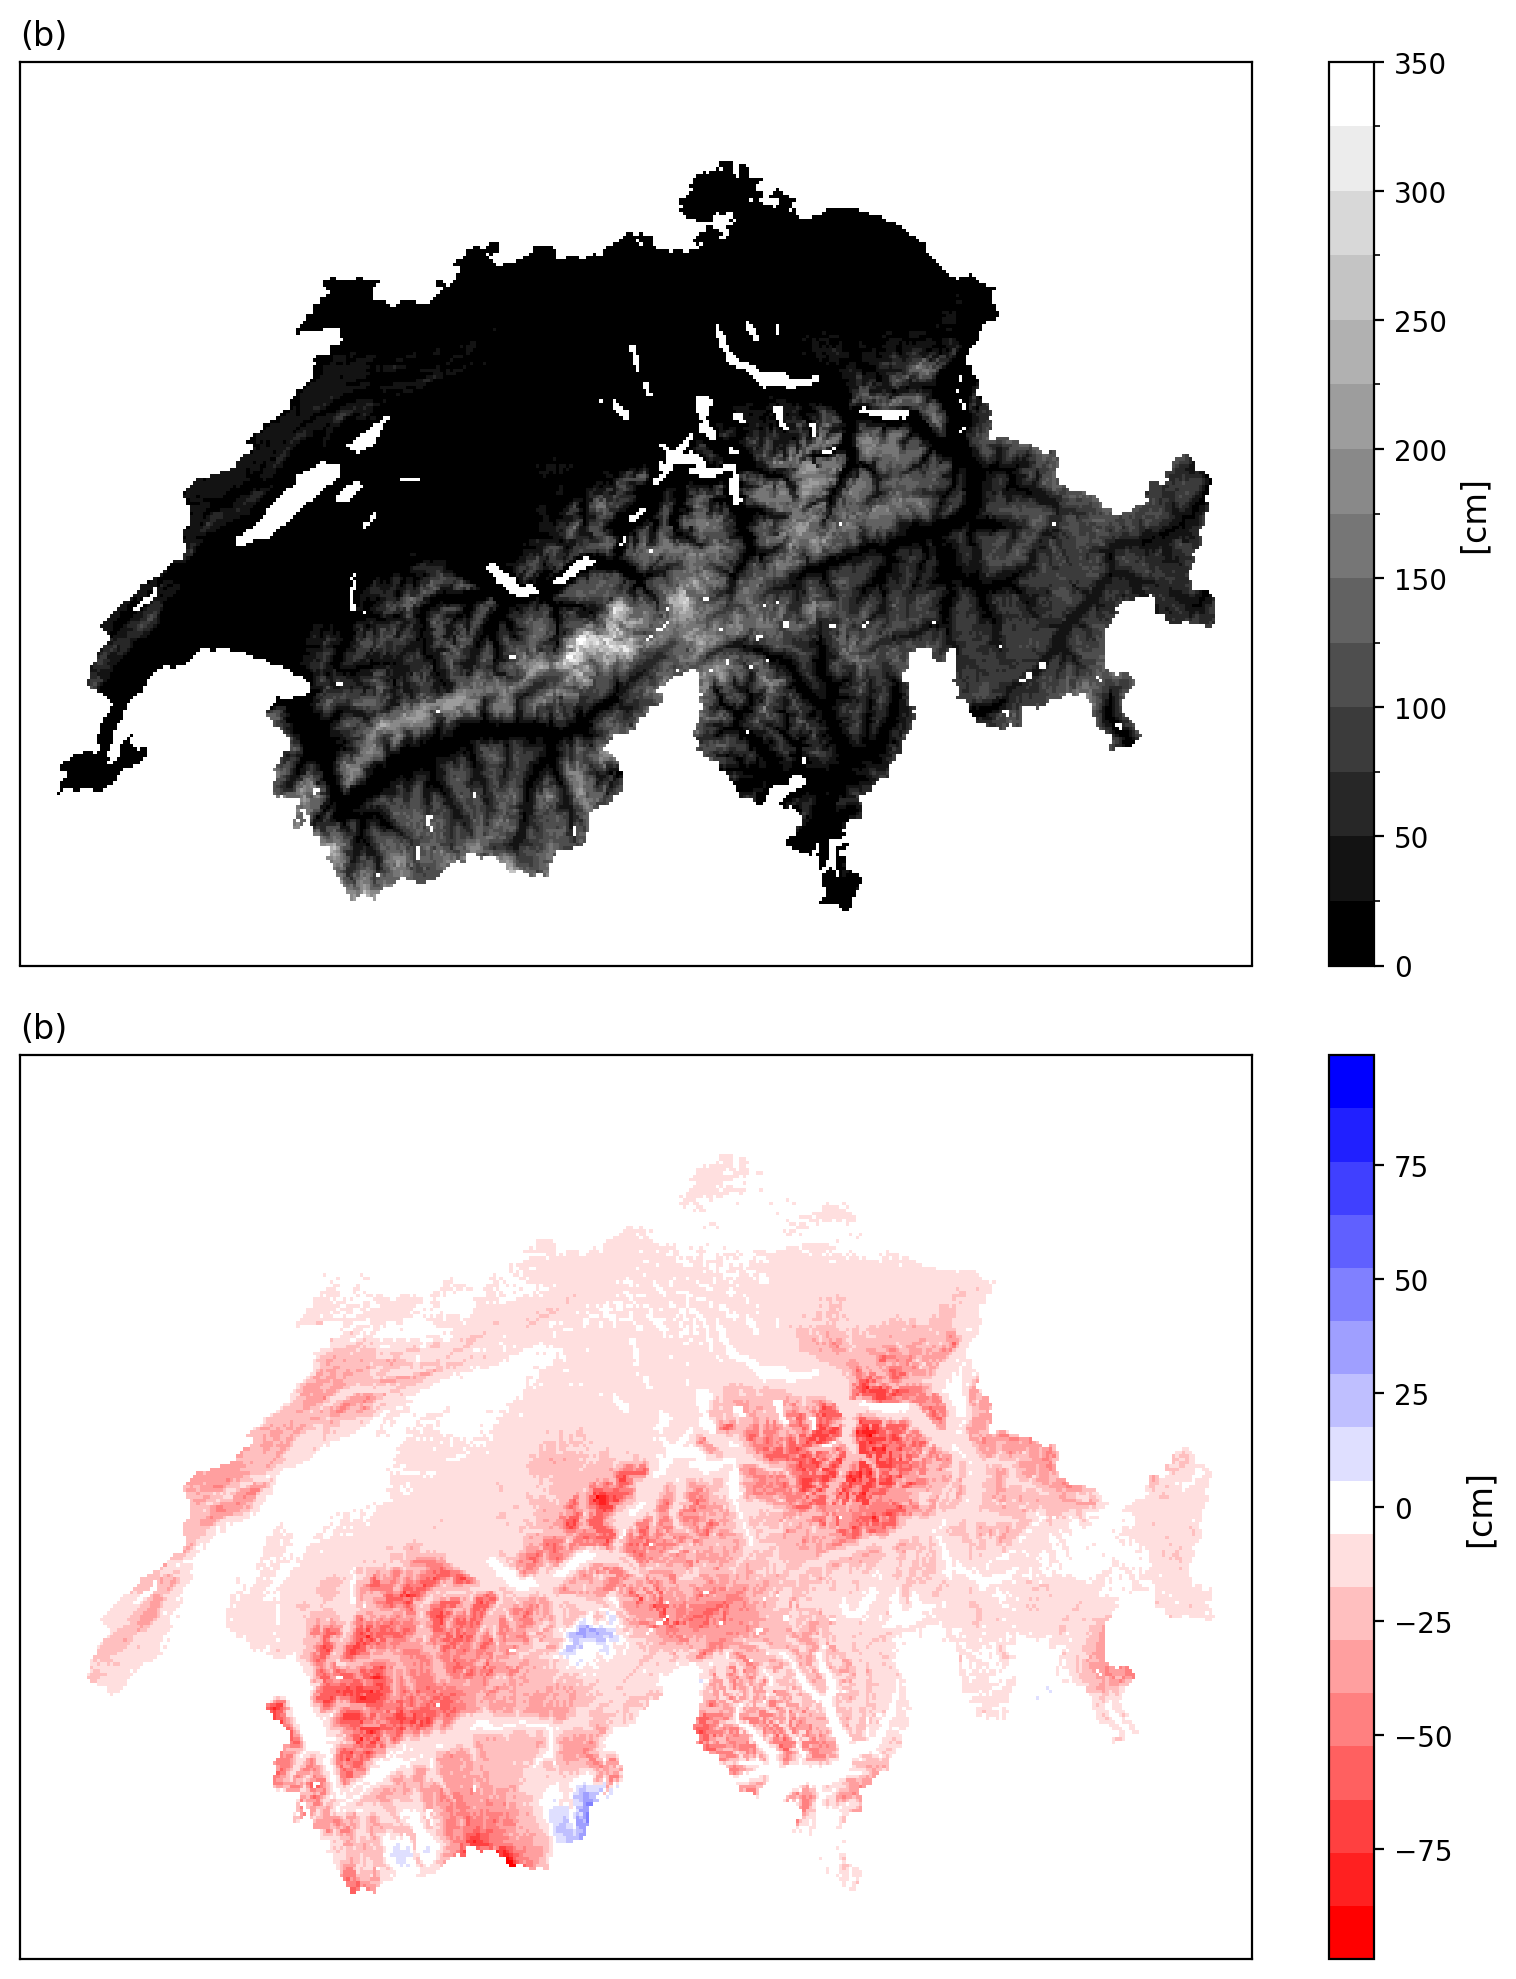

In [51]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10), dpi=200)



# Second plot
mesh2 = mean_dec_to_may.mean(dim="year").HSCLQMD.plot.pcolormesh(
    ax=axes[0],
    cmap="binary_r",  # Different color scale
    levels=17,
    add_colorbar=True
)
axes[0].set_title("(b)", fontsize=12, loc='left')
axes[0].set_title("")
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].tick_params(
    axis='both', which='both',
    bottom=False, top=False, left=False, right=False,
    labelbottom=False, labelleft=False
)
mesh2.colorbar.set_label('[cm]', fontsize=12)

# First plot
mesh1 = trend_60.plot.pcolormesh(
    ax=axes[1],
    cmap=bwr_custom,
    add_colorbar=True
)
axes[1].set_title("(b)", fontsize=12, loc='left')
axes[1].set_title("")
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].tick_params(
    axis='both', which='both',
    bottom=False, top=False, left=False, right=False,
    labelbottom=False, labelleft=False
)
mesh1.colorbar.set_label('[cm]', fontsize=12)

# Final layout adjustments
plt.tight_layout()
plt.savefig(plot_folder + "klimatrend_white.png", bbox_inches="tight")
plt.savefig(plot_folder + "klimatrend_white.pdf", bbox_inches="tight")
plt.show()
